In [23]:
import json_lines
from langdetect import detect
from langdetect import detect_langs
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.neural_network import MLPClassifier
import numpy as np
import threading
import time
import random

from sklearn.datasets import load_iris
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import pandas as pd
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

ALL_TAGS= ['CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNS', 'NNP', 'NNPS', 'PDT',
 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP',
 'WP$', 'WRB']
ACCEPTABLE_TAGS= ['FW', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNS', 'NNP', 'NNPS',
 'POS', 'RB', 'RBR', 'RBS', 'RP', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WP$']

MAX_FEATURES= 500 # incrasing this grants marginal increases in accuracy at the cost of run time
MIN_ENGLISH= 0.9999
LIMIT_INPUT_ROWS= 100 # You won't get as many rows of data in the final result as many are filtered out
K_FOLDS= 5
WNL = WordNetLemmatizer()

number_entries= 0
with open ('reviews.json', 'rb') as f:
    for item in json_lines.reader(f):
        number_entries+= 1

In [29]:
# READ IN INFO
reviews= []; polarity= []; are_early= []
included_indexs= []
j= 0
while j < LIMIT_INPUT_ROWS:
    randint= random.randint(0, number_entries-1)
    if not randint in already_included_indexs:
        included_indexs.append(randint)
        j+= 1
    
with open('reviews.json', 'rb') as f: # 5,000 entries in reviews.json
    for counter, item in enumerate(json_lines.reader(f)):
        if counter in included_indexs:
            reviews.append(item['text'])
            polarity.append(item['voted_up'])
            are_early.append(item['early_access'])

# END PRODUCTS: reviews, polarity, are_early

["Really â™¥â™¥â™¥â™¥â™¥â™¥â™¥ good fun. That's all I have to say for now.", 'Given the lack of "old-west" style games, this one is a great buy on sale. It has a short story mode and no multiplayer, but there is an arcade mode and a duels mode to keep you entertained for a few hours more. The graphics are last-gen, but it did not take much away from my experience. The old west lore was fun, the controls weren\'t frustrating, and it was nice to shoot some outlaws for a change instead of zombies or nazis.', 'è¶…å¥½çŽ©', 'Un gran juego su version remastered invita a jugarlo nuevamente, historia atrapante y mecanicas novedosas. un clasico que sin duda no puede faltar en la biblioteca', 'Supernatural izleyenler varmÄ± aranÄ±zda bilmiyorum. Ben hayranÄ±yÄ±mdÄ±r, her bÃ¶lÃ¼mÃ¼nÃ¼ baktÄ±m hatta birden fazla kez izlediÄŸim oldu. Korku filmlerine bayÄ±lÄ±rÄ±m. Conjuring serisi Ã¶zellikle. Ne zamandÄ±r aklÄ±mdaydÄ± Ã¶zellikle supernatural izlerken ÅŸunlarÄ±n bi oyunu olsa aynÄ± bÃ¶le yapsalar bid

In [3]:
# FILTER TEXT


#     try:
#         langs = detect_langs(item['text'])
#     except:
#         pass
#     for lang in langs:
#         if str(lang)[0:2] == 'en':
#             if float(str(lang)[3:]) > MIN_ENGLISH:
#                 reviews.append(item['text'])
#                 polarity.append(item['voted_up'])
#                 are_early.append(item['early_access'])
#                 break
#     else:
#         break


#print(reviews)
filtered_reviews= []
filtered_polarity= []
filtered_are_early= []
for i, text in enumerate(reviews):
    try:
        langs = detect_langs(item['text'])
    except:
        print("bitch!!!!!!!!!!!!!!!!")
        pass
    for lang in langs:
        if str(lang)[0:2] == 'en':
            if float(str(lang)[3:]) > MIN_ENGLISH:
                filtered_reviews.append(text)
                filtered_polarity.append(item['voted_up'])
                filtered_are_early.append(item['text'])
    #print("-------------------------------------")
    new_text= []
    split_text= text.split()
    tags= nltk.pos_tag(split_text)
    #print(tags)
    #print("#############")
    lemd_split_text= []
    for word in split_text:
        lemd_split_text.append(WNL.lemmatize(word))
    tags= nltk.pos_tag(lemd_split_text)
    #print(tags)
    for j, word in enumerate(lemd_split_text):
        if tags[j][1] in ACCEPTABLE_TAGS:
            new_text.append(word)
    filtered_reviews.append(new_text)
reviews= [' '.join([str(elem) for elem in sublist]) for sublist in filtered_reviews]

#END PRODUCTS: reviews (as a list of list! rather than a list or strings)

-------------------------------------
[('neat', 'JJ'), ('little', 'JJ'), ('game.', 'JJ'), ('play', 'NN'), ('if', 'IN'), ('your', 'PRP$'), ('staple', 'NN'), ('fps', 'NN'), ("game's", 'NN'), ('server', 'NN'), ('is', 'VBZ'), ('down', 'RB'), ('or', 'CC'), ('sth.', 'JJ'), ('maps', 'NNS'), ('and', 'CC'), ('weapon', 'VB'), ('distribution', 'NN'), ('system', 'NN'), ('needs', 'VBZ'), ('rework.', 'NN')]
#############
[('neat', 'JJ'), ('little', 'JJ'), ('game.', 'JJ'), ('play', 'NN'), ('if', 'IN'), ('your', 'PRP$'), ('staple', 'NN'), ('fps', 'NN'), ("game's", 'NN'), ('server', 'NN'), ('is', 'VBZ'), ('down', 'RB'), ('or', 'CC'), ('sth.', 'JJ'), ('map', 'NN'), ('and', 'CC'), ('weapon', 'NN'), ('distribution', 'NN'), ('system', 'NN'), ('need', 'VBP'), ('rework.', 'NN')]
-------------------------------------
[('Kinda', 'NNP'), ('decent', 'JJ'), ('f2p', 'NN'), ('mmorpg', 'NN'), ('that', 'WDT'), ('has', 'VBZ'), ('no', 'DT'), ('class', 'NN'), ('limitations(hooray!)(and', 'NN'), ('that', 'WDT'), ('game',

-------------------------------------
[('Love', 'NNP'), ('RDR2', 'NNP'), ('so', 'RB'), ('far,', 'JJ'), ('god', 'NN'), ('I', 'PRP'), ('have', 'VBP'), ('been', 'VBN'), ('waiting', 'VBG'), ('since', 'IN'), ('2010', 'CD'), ('(after', 'NN'), ('finishing', 'VBG'), ('Red', 'NNP'), ('Dead', 'NNP'), ('Redemption)', 'NNP'), ('for', 'IN'), ('this', 'DT'), ('damn', 'NN'), ('game!', 'NN'), ('Was', 'NNP'), ('mad', 'NN'), ('at', 'IN'), ('first,', 'NN'), ('would', 'MD'), ('not', 'RB'), ('launch.', 'VB'), ('I', 'PRP'), ('restarted', 'VBN'), ('pc,', 'NN'), ('ran', 'VBD'), ('steam', 'NN'), ('as', 'IN'), ('admin,', 'NN'), ('made', 'VBN'), ('sure', 'JJ'), ('my', 'PRP$'), ('xbone', 'NN'), ('controller', 'NN'), ('was', 'VBD'), ('off,', 'JJ'), ('and', 'CC'), ('it', 'PRP'), ('runs', 'VBZ'), ('just', 'RB'), ('fine', 'JJ'), ('now.', 'NN'), ('Will', 'NNP'), ('update', 'VB'), ('after', 'IN'), ('finishing', 'VBG'), ('the', 'DT'), ('whole', 'JJ'), ('game.', 'NN')]
#############
[('Love', 'NNP'), ('RDR2', 'NNP'), ('s

[('This', 'DT'), ('game', 'NN'), ('reminds', 'VBZ'), ('me', 'PRP'), ('of', 'IN'), ('when', 'WRB'), ('I', 'PRP'), ('was', 'VBD'), ('in', 'IN'), ('grade', 'NN'), ('school.', 'NN'), ('When', 'WRB'), ('I', 'PRP'), ('was', 'VBD'), ('in', 'IN'), ('3rd-4th', 'JJ'), ('grade', 'NN'), ('I', 'PRP'), ('made', 'VBD'), ('all', 'DT'), ("A's", 'NNP'), ('in', 'IN'), ('my', 'PRP$'), ('classes.', 'NN'), ('The', 'DT'), ('classes', 'NNS'), ("weren't", 'VBP'), ('that', 'DT'), ('hard', 'JJ'), ('and', 'CC'), ('everyone', 'NN'), ('thought', 'VBD'), ('that', 'IN'), ('I', 'PRP'), ('was', 'VBD'), ('this', 'DT'), ('super', 'JJ'), ('smart', 'JJ'), ('genius', 'NN'), ('child.', 'NN'), ('As', 'IN'), ('I', 'PRP'), ('got', 'VBD'), ('older,', 'JJ'), ('my', 'PRP$'), ('grades', 'NNS'), ('began', 'VBD'), ('to', 'TO'), ('drop', 'VB'), ('as', 'IN'), ('the', 'DT'), ('classes', 'NNS'), ('got', 'VBD'), ('harder.', 'JJ'), ('"What\'s', 'NNP'), ('wrong', 'NN'), ('with', 'IN'), ('you?"', 'JJ'), ('"You\'re', 'NNS'), ('so', 'RB'), ('s

[('If', 'IN'), ('you', 'PRP'), ('managed', 'VBD'), ('to', 'TO'), ('avoid', 'VB'), ('spoilers', 'NNS'), ('about', 'IN'), ('this', 'DT'), ('game', 'NN'), ('since', 'IN'), ('it', 'PRP'), ('was', 'VBD'), ('released,', 'JJ'), ('then', 'RB'), ('I', 'PRP'), ('can', 'MD'), ('tell', 'VB'), ('you', 'PRP'), ('that', 'IN'), ("it's", 'NN'), ('still', 'RB'), ('absolutely', 'RB'), ('worth', 'JJ'), ('playing.', 'JJ'), ('Life', 'NNP'), ('is', 'VBZ'), ('Strange', 'NNP'), ('is', 'VBZ'), ('a', 'DT'), ('story', 'NN'), ('about', 'IN'), ('Max', 'NNP'), ('Caulfield,', 'NNP'), ('a', 'DT'), ('girl', 'NN'), ('who', 'WP'), ('discovers', 'VBZ'), ('she', 'PRP'), ('can', 'MD'), ('rewind', 'VB'), ('time', 'NN'), ('as', 'IN'), ('she', 'PRP'), ('pleases.', 'VBZ'), ('She', 'PRP'), ('needs', 'VBZ'), ('to', 'TO'), ('overcome', 'VB'), ('high', 'JJ'), ('school', 'NN'), ('drama', 'NN'), ('and', 'CC'), ('save', 'VB'), ('Arcadia', 'NNP'), ('Bay', 'NNP'), ('from', 'IN'), ('itself', 'PRP'), ('with', 'IN'), ('her', 'PRP$'), ('chi

[('An', 'DT'), ('amazingly', 'RB'), ('fun', 'JJ'), ('game', 'NN'), ('while', 'IN'), ('it', 'PRP'), ('lasts.', 'VBZ'), ('Enjoyable', 'JJ'), ('in', 'IN'), ('every', 'DT'), ('aspect', 'NN'), ('from', 'IN'), ('shooting', 'VBG'), ('to', 'TO'), ('playing', 'VBG'), ('with', 'IN'), ('kills', 'NNS'), ('and', 'CC'), ('the', 'DT'), ('dialoge', 'NN'), ('is', 'VBZ'), ('top', 'JJ'), ('notch.', 'NN'), ('unfortunately', 'RB'), ('the', 'DT'), ('game', 'NN'), ('has', 'VBZ'), ('no', 'DT'), ('real', 'JJ'), ('replay', 'NN'), ('value', 'NN'), ('so', 'RB'), ('if', 'IN'), ('youc', 'JJR'), ('an', 'DT'), ('pick', 'NN'), ('it', 'PRP'), ('up', 'IN'), ('cheap', 'JJ'), ('i', 'NN'), ('wopuld', 'MD'), ('do', 'VB'), ('so.', 'NNS'), ('and', 'CC'), ('when', 'WRB'), ('you', 'PRP'), ('do', 'VBP'), ('say', 'VB'), ('hello', 'NN'), ('to', 'TO'), ('WAggleton', 'NNP'), ('P.', 'NNP'), ('Tallylicker', 'NNP'), ('for', 'IN'), ('me.', 'NN')]
#############
[('An', 'DT'), ('amazingly', 'RB'), ('fun', 'JJ'), ('game', 'NN'), ('while', 

[('Well,', 'NNP'), ('here', 'RB'), ('be', 'VB'), ('the', 'DT'), ('last', 'JJ'), ('part', 'NN'), ('of', 'IN'), ('the', 'DT'), ('series,', 'NN'), ('hailing', 'VBG'), ('from', 'IN'), ("RoseVerte's", 'NNP'), ('collection.', 'VBP'), ('It', 'PRP'), ('sure', 'JJ'), ('is', 'VBZ'), ('not', 'RB'), ('among', 'IN'), ('the', 'DT'), ('best', 'JJS'), ('in', 'IN'), ('their', 'PRP$'), ('catalogue', 'NN'), ('with', 'IN'), ('questionable', 'JJ'), ('art', 'NN'), ('choices', 'NNS'), ('and', 'CC'), ('some', 'DT'), ('blatant', 'JJ'), ('weeaboo', 'NN'), ('humor,', 'NN'), ('yet', 'RB'), ('still', 'RB'), ('the', 'DT'), ('long', 'JJ'), ('wait', 'NN'), ('in', 'IN'), ('the', 'DT'), ("series'", 'JJ'), ('completion', 'NN'), ('delivers', 'NNS'), ('justly', 'RB'), ('with', 'IN'), ('a', 'DT'), ('wonderful', 'JJ'), ('plot', 'NN'), ('twist.', 'NN'), ('We', 'PRP'), ('have', 'VBP'), ('waited', 'VBN'), ('so', 'RB'), ('long', 'RB'), ('for', 'IN'), ('the', 'DT'), ('revelation', 'NN'), ('of', 'IN'), ('our', 'PRP$'), ('hacker,'

[("It's", 'NNP'), ('alright.', 'NN')]
#############
[("It's", 'NNP'), ('alright.', 'NN')]
-------------------------------------
[('I', 'PRP'), ('just', 'RB'), ('love', 'VB'), ('sandbox', 'NN'), ('games', 'NNS'), ('and', 'CC'), ('this', 'DT'), ('one', 'CD'), ('is', 'VBZ'), ('one', 'CD'), ('of', 'IN'), ('the', 'DT'), ('best!', 'NN')]
#############
[('I', 'PRP'), ('just', 'RB'), ('love', 'VB'), ('sandbox', 'JJ'), ('game', 'NN'), ('and', 'CC'), ('this', 'DT'), ('one', 'CD'), ('is', 'VBZ'), ('one', 'CD'), ('of', 'IN'), ('the', 'DT'), ('best!', 'NN')]
-------------------------------------
[("It's", 'NNP'), ('such', 'PDT'), ('a', 'DT'), ('great', 'JJ'), ('game!', 'NN'), ('Tho', 'NNP'), ('it', 'PRP'), ('keeps', 'VBZ'), ('crashing', 'VBG'), ('for', 'IN'), ('me', 'PRP'), ('whenever', 'WRB'), ("I'm", 'NNP'), ('about', 'IN'), ('to', 'TO'), ('complete', 'VB'), ('a', 'DT'), ('mission,', 'NN'), ('but', 'CC'), ('anyhow.', 'VBZ'), ('The', 'DT'), ('open', 'JJ'), ('world', 'NN'), ('is', 'VBZ'), ('massive

[('"There', 'EX'), ('is', 'VBZ'), ('no', 'DT'), ('game"', 'NN'), ('is', 'VBZ'), ('a', 'DT'), ('humorous/puzzle-adventure', 'JJ'), ('game', 'NN'), ('with', 'IN'), ('great', 'JJ'), ('value', 'NN'), ('and', 'CC'), ('BRILLIANT', 'NNP'), ('ideas.', 'VBP'), ('+', 'NNP'), ('Gfx:', 'NNP'), ('Every', 'NNP'), ('part', 'NN'), ('of', 'IN'), ('it', 'PRP'), ('wa', 'VBZ'), ('fantastic,', 'JJ'), ('i', 'NN'), ('felt', 'VBD'), ('in', 'IN'), ('love', 'NN'), ('with', 'IN'), ("Point'n'Click", 'NNP'), ('Adventure', 'NNP'), ('part', 'NN'), ('especially.', 'NN'), ('+', 'NNP'), ('Sound', 'NNP'), ('desgin:', 'VBZ'), ('Amazing.', 'NNP'), ('All', 'PDT'), ('the', 'DT'), ('music', 'NN'), ('and', 'CC'), ('effect', 'NN'), ('were', 'VBD'), ('great!', 'JJ'), ('+', 'NNP'), ('Gameplay:', 'NNP'), ('Again...', 'NNP'), ('Amazing.', 'NNP'), ('All', 'NNP'), ('the', 'DT'), ('puzzle', 'NN'), ('were', 'VBD'), ('well', 'RB'), ('made,', 'JJ'), ('fun', 'NN'), ('all', 'PDT'), ('the', 'DT'), ('way,', 'NN'), ('never', 'RB'), ('bore', 

[('normally', 'RB'), ("don't", 'JJ'), ('write', 'JJ'), ('reviews', 'NNS'), ('but', 'CC'), ('wish', 'VB'), ('this', 'DT'), ('one', 'CD'), ('get', 'NN'), ('more', 'JJR'), ('attentions', 'NNS'), ("it's", 'VBP'), ('fun', 'NN'), ('unique', 'JJ'), ('strategy+fps', 'NN'), ('team', 'NN'), ('game', 'NN'), ('with', 'IN'), ('marine', 'NN'), ('and', 'CC'), ('alien.', 'VB'), ('both', 'DT'), ('sides', 'NNS'), ('have', 'VBP'), ('a', 'DT'), ('commander', 'NN'), ('who', 'WP'), ('have', 'VBP'), ('top-down', 'JJ'), ('view,', 'NN'), ('set', 'VBN'), ('up', 'RP'), ('blue', 'JJ'), ('print', 'NN'), ('buildings', 'NNS'), ('anywhere', 'RB'), ('on', 'IN'), ('the', 'DT'), ('map,', 'NN'), ('manage', 'NN'), ('the', 'DT'), ('team', 'NN'), ('resources', 'NNS'), ('for', 'IN'), ('upgrading', 'VBG'), ('technologies', 'NNS'), ('+', 'VBP'), ('equipments', 'NNS'), ('(marine)', 'FW'), ('and', 'CC'), ('evolution', 'NN'), ('levels', 'NNS'), ('+', 'VBP'), ('abilities', 'NNS'), ('(aliens)', 'NNP'), ('of', 'IN'), ('whole', 'JJ')

[('â€˜Payday', 'JJ'), ('2â€™', 'CD'), ('is', 'VBZ'), ('a', 'DT'), ('fast-paced,', 'JJ'), ('slick,', 'JJ'), ('Co-operative', 'JJ'), ('First-Person', 'NNP'), ('Shooter', 'NNP'), ('(FPS)', 'NNP'), ('and', 'CC'), ('a', 'DT'), ('strong', 'JJ'), ('sequel', 'NN'), ('to', 'TO'), ('2011â€™s', 'CD'), ('cult-classic', 'JJ'), ('â€˜Payday:', 'NN'), ('The', 'DT'), ('Heistâ€™.', 'NNP'), ('While', 'IN'), ('the', 'DT'), ('first', 'JJ'), ('entry', 'NN'), ('in', 'IN'), ('the', 'DT'), ('series', 'NN'), ('wa', 'VBD'), ('an', 'DT'), ('un-polished', 'JJ'), ('gem,', 'NN'), ('â€˜Payday', 'JJ'), ('2â€™', 'CD'), ('is', 'VBZ'), ('bigger,', 'VBN'), ('badder', 'NN'), ('and', 'CC'), ('flashier', 'NN'), ('in', 'IN'), ('nearly', 'RB'), ('every', 'DT'), ('regard', 'NN'), ('-', ':'), ('a', 'DT'), ('taut,', 'JJ'), ('adrenaline-shot', 'JJ'), ('affair', 'NN'), ('with', 'IN'), ('explosive', 'JJ'), ('running', 'VBG'), ('gun-battles', 'NNS'), ('around', 'IN'), ('every', 'DT'), ('corner.', 'NN'), ('Gamers', 'NNP'), ('once', 'R

[('At', 'IN'), ('last;', 'NN'), ('we', 'PRP'), ('finally', 'RB'), ('have', 'VBP'), ('a', 'DT'), ('new', 'JJ'), ('Terminator', 'NNP'), ('game', 'NN'), ('-', ':'), ('and', 'CC'), ("it's", 'VB'), ('an', 'DT'), ('FPS!', 'NNP'), ('Sounds', 'NNP'), ('great,', 'NN'), ('but', 'CC'), ('how', 'WRB'), ('good', 'JJ'), ('is', 'VBZ'), ('it?', 'JJ'), ('The', 'DT'), ('game', 'NN'), ('start', 'VB'), ('off', 'RP'), ('fairly', 'RB'), ('slow,', 'JJ'), ('but', 'CC'), ('pick', 'VBZ'), ('up', 'RP'), ('at', 'IN'), ('around', 'IN'), ('an', 'DT'), ('1', 'CD'), ('1/2', 'CD'), ('to', 'TO'), ('2', 'CD'), ('hour', 'NN'), ('in.', 'NN'), ('This', 'DT'), ('is', 'VBZ'), ('the', 'DT'), ('most', 'RBS'), ('boring', 'JJ'), ('part', 'NN'), ('of', 'IN'), ('the', 'DT'), ('game:', 'NN'), ("you'll", 'NN'), ('mostly', 'RB'), ('be', 'VB'), ('walking', 'VBG'), ('around', 'IN'), ('a', 'DT'), ('barren', 'NN'), ('map,', 'NN'), ('looting', 'VBG'), ('crafting', 'VBG'), ('material,', 'NN'), ('picking', 'VBG'), ('locks,', 'NN'), ('and', 

[('Wonderful', 'JJ'), ('game!', 'VBD'), ('The', 'DT'), ('game', 'NN'), ('takes', 'VBZ'), ('place', 'NN'), ('in', 'IN'), ('1930,', 'CD'), ('when', 'WRB'), ('Nancy', 'NNP'), ('Drew', 'NNP'), ('visits', 'VBZ'), ('her', 'PRP$'), ('friend', 'NN'), ('Emily,', 'NN'), ('at', 'IN'), ('the', 'DT'), ('Lilac', 'NNP'), ('Inn...there', 'NNP'), ('Nancy', 'NNP'), ('encounters', 'VBZ'), ('her', 'PRP$'), ('first', 'JJ'), ('mystery,', 'NN'), ('and', 'CC'), ('becomes', 'VBZ'), ('the', 'DT'), ('detective', 'NN'), ('we', 'PRP'), ('know', 'VBP'), ('and', 'CC'), ('love.', 'VBP'), (':)', 'NN'), ('I', 'PRP'), ('enjoyed', 'VBD'), ('this', 'DT'), ('game', 'NN'), ('enormously.', 'VBZ'), ('The', 'DT'), ('dialogue', 'NN'), ('is', 'VBZ'), ('solid', 'JJ'), ('and', 'CC'), ('the', 'DT'), ('voice', 'NN'), ('acting', 'VBG'), ('is', 'VBZ'), ('less', 'RBR'), ('wonky', 'JJ'), ('than', 'IN'), ('in', 'IN'), ('other', 'JJ'), ('games.', 'NN'), ('The', 'DT'), ('characters', 'NNS'), ('have', 'VBP'), ('fluid', 'VBN'), ('movement,',

[('This', 'DT'), ('is', 'VBZ'), ('my', 'PRP$'), ('first', 'JJ'), ('horror', 'NN'), ('game', 'NN'), ('I`ve', 'NNP'), ('played', 'VBD'), ('in', 'IN'), ('my', 'PRP$'), ('childhood,', 'NN'), ('it`s', 'VBZ'), ('a', 'DT'), ('great', 'JJ'), ('game,', 'NN'), ('the', 'DT'), ('series', 'NN'), ('are', 'VBP'), ('awesome.', 'JJ'), ('BUY', 'NNP'), ('IT.', 'NNP'), ('P.S.', 'NNP'), ('Did', 'NNP'), ('you', 'PRP'), ('know', 'VBP'), ('there', 'EX'), ('is', 'VBZ'), ('a', 'DT'), ('film', 'NN'), ('about', 'IN'), ('Doom', 'NNP'), ('?', '.')]
#############
[('This', 'DT'), ('is', 'VBZ'), ('my', 'PRP$'), ('first', 'JJ'), ('horror', 'NN'), ('game', 'NN'), ('I`ve', 'NNP'), ('played', 'VBD'), ('in', 'IN'), ('my', 'PRP$'), ('childhood,', 'NN'), ('it`s', 'VBZ'), ('a', 'DT'), ('great', 'JJ'), ('game,', 'NN'), ('the', 'DT'), ('series', 'NN'), ('are', 'VBP'), ('awesome.', 'JJ'), ('BUY', 'NNP'), ('IT.', 'NNP'), ('P.S.', 'NNP'), ('Did', 'NNP'), ('you', 'PRP'), ('know', 'VBP'), ('there', 'EX'), ('is', 'VBZ'), ('a', 'DT')

[('This', 'DT'), ('is', 'VBZ'), ('one', 'CD'), ('of', 'IN'), ('the', 'DT'), ('best', 'JJS'), ('games', 'NNS'), ('of', 'IN'), ('all', 'DT'), ('time', 'NN')]
#############
[('This', 'DT'), ('is', 'VBZ'), ('one', 'CD'), ('of', 'IN'), ('the', 'DT'), ('best', 'JJS'), ('game', 'NN'), ('of', 'IN'), ('all', 'DT'), ('time', 'NN')]
-------------------------------------
[('Hey,', 'NNP'), ('I', 'PRP'), ('can', 'MD'), ('give', 'VB'), ('bayonet', 'NN'), ('my', 'PRP$'), ('for', 'IN'), ('all', 'DT'), ('of', 'IN'), ('your', 'PRP$'), ('csgo', 'NN'), ('sealed', 'VBD'), ('graffities', 'NNS'), ('(Im', 'NNP'), ('collecting', 'VBG'), ('them)', 'RB'), ('so', 'RB'), ('if', 'IN'), ("it's", 'JJ'), ('ok', 'NN'), ('for', 'IN'), ('you', 'PRP'), ('send', 'VBP'), ('me', 'PRP'), ('trade', 'NN'), ('offer', 'VBP'), ('please.', 'JJ'), ('Link', 'NNP'), ('in', 'IN'), ('my', 'PRP$'), ('bio', 'NN')]
#############
[('Hey,', 'NNP'), ('I', 'PRP'), ('can', 'MD'), ('give', 'VB'), ('bayonet', 'NN'), ('my', 'PRP$'), ('for', 'IN'), 

[('Black', 'NNP'), ('Book', 'NNP'), ('Prologue', 'NNP'), ('is', 'VBZ'), ('a', 'DT'), ('dark,', 'JJ'), ('mysterious,', 'NN'), ('wondrously', 'RB'), ('poetic', 'JJ'), ('RPG', 'NNP'), ('set', 'NN'), ('in', 'IN'), ('the', 'DT'), ('world', 'NN'), ('of', 'IN'), ('slavic', 'JJ'), ('folklore', 'NN'), ('and', 'CC'), ('mythology.', 'NN'), ('Endlessly', 'RB'), ('original,', 'VBZ'), ('armed', 'VBN'), ('with', 'IN'), ('layer', 'NN'), ('upon', 'IN'), ('layer', 'NN'), ('of', 'IN'), ('intricate', 'JJ'), ('lore', 'NN'), ('and', 'CC'), ('backstory,', 'VB'), ('Black', 'NNP'), ('Book', 'NNP'), ('Prologue', 'NNP'), ('tell', 'VBP'), ('only', 'RB'), ('a', 'DT'), ('small', 'JJ'), ('part', 'NN'), ('of', 'IN'), ('the', 'DT'), ('life', 'NN'), ('and', 'CC'), ('deed', 'NN'), ('of', 'IN'), ('a', 'DT'), ('young', 'JJ'), ('witch', 'NN'), ('Vasilisa', 'NNP'), ('a', 'DT'), ("she's", 'NN'), ('trying', 'VBG'), ('to', 'TO'), ('learn', 'VB'), ('to', 'TO'), ('control', 'VB'), ('the', 'DT'), ('ominous', 'JJ'), ('Black', 'NNP

[('For', 'IN'), ('everyone', 'NN'), ('else,', 'NN'), ('this', 'DT'), ('is', 'VBZ'), ('a', 'DT'), ('MUST', 'NNP'), ('BUY', 'NNP'), ('to', 'TO'), ('have', 'VB'), ('in', 'IN'), ('your', 'PRP$'), ('stable', 'NN'), ('of', 'IN'), ('massively', 'RB'), ('multiplayer', 'JJ'), ('FPS', 'NNP'), ('games.', 'NN'), ('It', 'PRP'), ('ha', 'VBZ'), ('a', 'DT'), ('solid,', 'NN'), ('hardcore', 'NN'), ('foundation', 'NN'), ('that', 'WDT'), ('will', 'MD'), ('keep', 'VB'), ('you', 'PRP'), ('engaged', 'VBN'), ('for', 'IN'), ('hours.', 'NN'), ('For', 'IN'), ('others', 'NNS'), ('returning', 'VBG'), ('to', 'TO'), ('the', 'DT'), ('series,', 'NN'), ('it', 'PRP'), ('still', 'RB'), ('ha', 'VBZ'), ('the', 'DT'), ('trademarked/standard', 'NN'), ('and', 'CC'), ('ass-kicking', 'JJ'), ('weapons.', 'NN'), ('Insurgency', 'NNP'), ('ha', 'VBD'), ('some', 'DT'), ('of', 'IN'), ('the', 'DT'), ('best', 'JJS'), ('gun', 'NN'), ('mechanic', 'NN'), ('and', 'CC'), ('map', 'NN'), ('design', 'NN'), ('on', 'IN'), ('the', 'DT'), ('market.

[('such', 'JJ'), ('a', 'DT'), ('fun', 'JJ'), ('game', 'NN'), ('to', 'TO'), ('play', 'VB'), ('with', 'IN'), ('friends', 'NNS'), ('and', 'CC'), ('nice', 'JJ'), ('to', 'TO'), ('just', 'RB'), ('chill', 'VB'), ('out', 'RP'), ('and', 'CC'), ('relax.', 'VB')]
#############
[('such', 'JJ'), ('a', 'DT'), ('fun', 'JJ'), ('game', 'NN'), ('to', 'TO'), ('play', 'VB'), ('with', 'IN'), ('friend', 'NN'), ('and', 'CC'), ('nice', 'JJ'), ('to', 'TO'), ('just', 'RB'), ('chill', 'VB'), ('out', 'RP'), ('and', 'CC'), ('relax.', 'VB')]
-------------------------------------
[('Addon', 'NNP'), ('of', 'IN'), ('the', 'DT'), ('year/10', 'NN')]
#############
[('Addon', 'NNP'), ('of', 'IN'), ('the', 'DT'), ('year/10', 'NN')]
-------------------------------------
[('Dinosaur', 'NNP'), ('Hunt', 'NNP'), ('First', 'NNP'), ('Blood', 'NNP'), ('is', 'VBZ'), ('a', 'DT'), ('sequel', 'NN'), ('to', 'TO'), ('a', 'DT'), ('first', 'JJ'), ('Dinosaur', 'NNP'), ('Hunt', 'NNP'), ('game', 'NN'), ('and', 'CC'), ('is', 'VBZ'), ('a', 'DT

[('This', 'DT'), ('wa', 'NN'), ('surprising.', 'NN'), ('And', 'CC'), ('to', 'TO'), ('be', 'VB'), ('quick', 'JJ'), ('about', 'IN'), ('saying', 'VBG'), ('so,', 'NN'), ('I', 'PRP'), ('want', 'VBP'), ('more,', 'JJ'), ('and', 'CC'), ('I', 'PRP'), ('want', 'VBP'), ('this', 'DT'), ('to', 'TO'), ('become', 'VB'), ('the', 'DT'), ('Norm.', 'NNP'), ('Basically', 'NNP'), ("it's", 'VBP'), ('Devolver', 'NNP'), ("Digital's", 'NNP'), ('own', 'JJ'), ('private', 'JJ'), ('E3,', 'NNP'), ('with', 'IN'), ('subtle', 'JJ'), ('stealth', 'NN'), ('mechanic', 'NN'), ('(Nothing', 'VBG'), ('more', 'JJR'), ('than', 'IN'), ("'don't", 'CD'), ('get', 'VB'), ('seen,', 'JJ'), ('shoot', 'NN'), ('to', 'TO'), ('stun).', 'VB'), ('It', 'PRP'), ('showed', 'VBD'), ('off', 'RP'), ('a', 'DT'), ('bunch', 'NN'), ('of', 'IN'), ('game', 'NN'), ('and', 'CC'), ('their', 'PRP$'), ('trailer', 'NN'), ('in', 'IN'), ('really', 'RB'), ('pretty', 'JJ'), ('private', 'JJ'), ('environment', 'NN'), ('with', 'IN'), ('minimalistic', 'JJ'), ('game',

[('~', 'NN'), ('DIFFICULTY', 'NNP'), ('~', 'NNP'), ('ðŸ”²', 'NNP'), ('My', 'NNP'), ('grandma', 'NN'), ('could', 'MD'), ('play', 'VB'), ('it', 'PRP'), ('ðŸ”²', 'NNP'), ('Easy', 'NNP'), ('âœ…', 'NNP'), ('Normal', 'NNP'), ('ðŸ”²', 'NNP'), ('Hard', 'NNP'), ('ðŸ”²', 'VBZ'), ('A', 'NNP'), ('challenge', 'NN'), ('to', 'TO'), ('be', 'VB'), ('reckoned', 'VBN'), ('ðŸ”²', 'NNP'), ('In', 'IN'), ('the', 'DT'), ('heat', 'NN'), ('of', 'IN'), ('confrontation,', 'JJ'), ('treat', 'VB'), ('your', 'PRP$'), ('opponent', 'NN'), ('with', 'IN'), ('respect', 'NN'), ('~', 'NN'), ('GRAPHICS', 'NNP'), ('~', 'NNP'), ('ðŸ”²', 'NNP'), ('MS', 'NNP'), ('Paint', 'NNP'), ('ðŸ”²', 'NNP'), ('Bad', 'NNP'), ('ðŸ”²', 'NNP'), ('Meh', 'NNP'), ('âœ…', 'NNP'), ('Graphics', 'NNP'), ("don't", 'VBP'), ('matter', 'NN'), ('for', 'IN'), ('this', 'DT'), ('game', 'NN'), ('ðŸ”²', 'RB'), ('Good', 'NNP'), ('(nothing', 'VBG'), ('special)', 'NN'), ('ðŸ”²', 'VBD'), ('An', 'DT'), ('original', 'JJ'), ('artistic', 'JJ'), ('direction', 'NN'), ('ðŸ

[('Let', 'VB'), ('me', 'PRP'), ('start', 'VB'), ('off', 'RP'), ('by', 'IN'), ('saying,', 'NN'), ('I', 'PRP'), ('was', 'VBD'), ('very', 'RB'), ('skeptical', 'JJ'), ('of', 'IN'), ('purchasing', 'VBG'), ('this', 'DT'), ('game', 'NN'), ('at', 'IN'), ('first.', 'PDT'), ('The', 'DT'), ('reason?', 'NN'), ('I', 'PRP'), ('had', 'VBD'), ('played', 'VBN'), ('the', 'DT'), ('original', 'JJ'), ('Shantae', 'NNP'), ('on', 'IN'), ('the', 'DT'), ('Gameboy', 'NNP'), ('Color', 'NNP'), ('when', 'WRB'), ('I', 'PRP'), ('was', 'VBD'), ('younger', 'JJR'), ('and', 'CC'), ("wasn't", 'VB'), ('too', 'RB'), ('big', 'JJ'), ('a', 'DT'), ('fan', 'NN'), ('of', 'IN'), ('it,', 'JJ'), ('however', 'RB'), ('I', 'PRP'), ('pushed', 'VBP'), ('on', 'IN'), ('and', 'CC'), ('tried', 'VBD'), ('out', 'RP'), ('this', 'DT'), ('game', 'NN'), ('and', 'CC'), ('I', 'PRP'), ('honestly', 'RB'), ('have', 'VBP'), ('no', 'DT'), ('regrets', 'NNS'), ('with', 'IN'), ('my', 'PRP$'), ('purchase', 'NN'), ('at', 'IN'), ('all.', 'NN'), ('This', 'DT'),

[("What's", 'NNP'), ('there', 'EX'), ('to', 'TO'), ('say?', 'VB'), ("It's", 'NNP'), ('GTA,', 'NNP'), ('Single', 'NNP'), ('player', 'NN'), ('ha', 'VBD'), ('a', 'DT'), ('decent', 'JJ'), ('story,', 'NN'), ('for', 'IN'), ('the', 'DT'), ('first', 'JJ'), ('time', 'NN'), ('including', 'VBG'), ('3', 'CD'), ('playable', 'JJ'), ('character', 'NN'), ('and', 'CC'), ('a', 'DT'), ('always,', 'JJ'), ('mod', 'NN'), ('for', 'IN'), ('those', 'DT'), ('that', 'WDT'), ('want', 'VBP'), ('more.', 'JJ'), ('Online', 'NNP'), ('is', 'VBZ'), ('a', 'DT'), ('bit', 'NN'), ('of', 'IN'), ('a', 'DT'), ('hit', 'NN'), ('and', 'CC'), ('miss.', 'NN'), ('There', 'EX'), ('are', 'VBP'), ('hackers,', 'JJ'), ('just', 'RB'), ('like', 'IN'), ('in', 'IN'), ('every', 'DT'), ('other', 'JJ'), ('online', 'NN'), ('game,', 'NN'), ('if', 'IN'), ("he's", 'JJ'), ('not', 'RB'), ('bothering', 'VBG'), ('you', 'PRP'), ('then', 'RB'), ('you', 'PRP'), ('can', 'MD'), ('keep', 'VB'), ('doing', 'VBG'), ('your', 'PRP$'), ('thing,', 'NNS'), ('otherwi

[('Pretty', 'NNP'), ('hardcore', 'NN'), ('and', 'CC'), ('realistic', 'JJ'), ('fps', 'NN'), ('game.', 'NN'), ('I', 'PRP'), ('like', 'IN'), ('how', 'WRB'), ('the', 'DT'), ('game', 'NN'), ('take', 'VB'), ('place', 'NN'), ('in', 'IN'), ('the', 'DT'), ('middle', 'JJ'), ('east', 'NN'), ('and', 'CC'), ('also', 'RB'), ('mainly', 'RB'), ('how', 'WRB'), ('combat', 'NN'), ('work', 'NN'), ('in', 'IN'), ('this', 'DT'), ('game.', 'NN'), ('Guns', 'NNP'), ('are', 'VBP'), ('interesting', 'VBG'), ('and', 'CC'), ('I', 'PRP'), ('really', 'RB'), ('feel', 'VB'), ('more', 'JJR'), ('intense', 'JJ'), ('gunfight', 'NN'), ('than', 'IN'), ('most', 'JJS'), ('other', 'JJ'), ('fps', 'JJ'), ('game', 'NN'), ('I', 'PRP'), ('played', 'VBD'), ('before.', 'NN'), ('Sadly', 'RB'), ("it's", 'JJ'), ('dying', 'VBG'), ('(especially', 'RB'), ('competitive', 'JJ'), ('which', 'WDT'), ('is', 'VBZ'), ('the', 'DT'), ('reason', 'NN'), ('I', 'PRP'), ('didnt', 'VBP'), ('bother', 'RB'), ('with', 'IN'), ('it)', 'NN'), ('and', 'CC'), ('It'

[('Brawlhalla', 'NNP'), ('is', 'VBZ'), ('an', 'DT'), ('amazing', 'JJ'), ('way', 'NN'), ('to', 'TO'), ('spend', 'VB'), ('your', 'PRP$'), ('time', 'NN'), ('with', 'IN'), ('friends', 'NNS'), ('or', 'CC'), ('even', 'RB'), ('alone.', 'JJ'), ('Playing', 'VBG'), ('Alone,', 'NNP'), ('you', 'PRP'), ('feel', 'VBP'), ('rushed', 'VBN'), ('to', 'TO'), ('win', 'VB'), ('in', 'IN'), ('online', 'JJ'), ('matches,', 'NN'), ('but', 'CC'), ('with', 'IN'), ('friends,', 'NN'), ('you', 'PRP'), ('get', 'VBP'), ('to', 'TO'), ('gauge', 'VB'), ('how', 'WRB'), ('good', 'JJ'), ('at', 'IN'), ('playing', 'VBG'), ('you', 'PRP'), ('really', 'RB'), ('are,', 'VB'), ('brawlhalla', 'NN'), ('is', 'VBZ'), ('a', 'DT'), ('great', 'JJ'), ('way', 'NN'), ('to', 'TO'), ('have', 'VB'), ('casual', 'JJ'), ('fun', 'NN'), ('with', 'IN'), ('your', 'PRP$'), ('friends', 'NNS'), ('while', 'IN'), ('having', 'VBG'), ('an', 'DT'), ('amazing', 'JJ'), ('competitive', 'JJ'), ('time.', 'NN')]
#############
[('Brawlhalla', 'NNP'), ('is', 'VBZ'), (

[('Great', 'NNP'), ('game,', 'NN'), ('brings', 'VBZ'), ('back', 'RB'), ('great', 'JJ'), ('memorys,', 'NN'), ('only', 'RB'), ('thing', 'NN'), ('that', 'IN'), ('annoys', 'VBZ'), ('me,', 'VB'), ('my', 'PRP$'), ('game', 'NN'), ('seems', 'VBZ'), ('to', 'TO'), ('be', 'VB'), ('somewhat', 'RB'), ('"slower"', 'JJ'), ('8/10', 'CD')]
#############
[('Great', 'NNP'), ('game,', 'NN'), ('brings', 'VBZ'), ('back', 'RB'), ('great', 'JJ'), ('memorys,', 'NN'), ('only', 'RB'), ('thing', 'NN'), ('that', 'IN'), ('annoys', 'VBZ'), ('me,', 'VB'), ('my', 'PRP$'), ('game', 'NN'), ('seems', 'VBZ'), ('to', 'TO'), ('be', 'VB'), ('somewhat', 'RB'), ('"slower"', 'JJ'), ('8/10', 'CD')]
-------------------------------------
[('interesting', 'VBG'), ('game..', 'NN'), ('in', 'IN'), ('the', 'DT'), ('14th', 'CD'), ('machine', 'NN'), ('war', 'NN'), ('you', 'PRP'), ('can', 'MD'), ('play', 'VB'), ('as', 'IN'), ('2b', 'CD'), ('which', 'WDT'), ('is', 'VBZ'), ('an', 'DT'), ('android', 'JJ'), ('built', 'NN'), ('for', 'IN'), ('b

[('What', 'WP'), ('a', 'DT'), ('bunch', 'NN'), ('of', 'IN'), ('entitled', 'JJ'), ('crybabies.', 'NN'), ('Bad', 'NNP'), ('korean', 'JJ'), ('translation?', 'NN'), ('So', 'NNP'), ('what?', 'WP'), ('Is', 'VBZ'), ('your', 'PRP$'), ('"thumbs', 'JJ'), ('down"', 'JJ'), ('justified?', 'NN'), ('Of', 'IN'), ('course', 'NN'), ('not.', 'JJ'), ("It's", 'NNP'), ('like', 'IN'), ('not', 'RB'), ('getting', 'VBG'), ('a', 'DT'), ('PHD', 'NNP'), ('because', 'IN'), ('you', 'PRP'), ('made', 'VBD'), ('a', 'DT'), ('couple', 'JJ'), ('spelling', 'NN'), ('mistakes.', 'NN'), ('I', 'PRP'), ('am', 'VBP'), ('ashamed', 'VBN'), ('that', 'IN'), ('this', 'DT'), ('game', 'NN'), ('had', 'VBD'), ('such', 'PDT'), ('a', 'DT'), ('toxic', 'JJ'), ('korean', 'JJ'), ('fanbase.', 'NN'), ('Not', 'RB'), ('only', 'RB'), ('korean', 'JJ'), ('jumped', 'VBD'), ('on', 'IN'), ('this', 'DT'), ('bangwagon.', 'NN'), ('This', 'DT'), ('game', 'NN'), ('is', 'VBZ'), ('one', 'CD'), ('of', 'IN'), ('the', 'DT'), ('best', 'JJS'), ("I've", 'NNP'), ('pl

[('Empires', 'NNS'), ('Apart', 'NNP'), ('is', 'VBZ'), ('an', 'DT'), ('indie', 'JJ'), ('title', 'NN'), ('made', 'VBN'), ('by', 'IN'), ('a', 'DT'), ('small', 'JJ'), ('team,', 'NN'), ('it', 'PRP'), ('is', 'VBZ'), ('heavily', 'RB'), ('inspired', 'VBN'), ('by', 'IN'), ('Age', 'NNP'), ('of', 'IN'), ('Empires', 'NNP'), ('2', 'CD'), ('in', 'IN'), ('units', 'NNS'), ('and', 'CC'), ('theming,', 'JJ'), ("it's", 'NN'), ('really', 'RB'), ('good', 'JJ'), ('at', 'IN'), ('what', 'WP'), ('it', 'PRP'), ('does', 'VBZ'), ('and', 'CC'), ('an', 'DT'), ('amazing', 'JJ'), ('amount', 'NN'), ('of', 'IN'), ('fun.', 'NN'), ("I've", 'NNP'), ('never', 'RB'), ('been', 'VBN'), ('much', 'RB'), ('of', 'IN'), ('a', 'DT'), ('multiplayer', 'NN'), ('person,', 'NN'), ('but', 'CC'), ('this', 'DT'), ('title', 'NN'), ('had', 'VBD'), ('me', 'PRP'), ('hooked', 'JJ'), ('since', 'IN'), ('I', 'PRP'), ('entered', 'VBD'), ('beta.', 'NN'), ('A', 'NNP'), ('few', 'JJ'), ('things', 'NNS'), ('are', 'VBP'), ('good', 'JJ'), ('to', 'TO'), ('n

[('Party', 'NNP'), ('hard', 'JJ'), ('2', 'CD'), ('is', 'VBZ'), ('a', 'DT'), ('game', 'NN'), ('about', 'IN'), ('a', 'DT'), ('guy', 'NN'), ('getting', 'VBG'), ('waken', 'VBN'), ('up', 'RP'), ('by', 'IN'), ('his', 'PRP$'), ('neighbors', 'NNS'), ('at', 'IN'), ('3', 'CD'), ('am', 'VBP'), ('so', 'RB'), ('he', 'PRP'), ('decides', 'VBZ'), ('to', 'TO'), ('go', 'VB'), ('on', 'IN'), ('a', 'DT'), ('killing', 'VBG'), ('spree', 'NN'), ('to', 'TO'), ('make', 'VB'), ('things', 'NNS'), ('tranquil.', 'VB'), ('The', 'DT'), ('game', 'NN'), ('is', 'VBZ'), ('a', 'DT'), ('combination', 'NN'), ('between', 'IN'), ('Hitman', 'NNP'), ('and', 'CC'), ('Hotline', 'NNP'), ('Miami.', 'NNP'), ('The', 'DT'), ('graphics', 'NNS'), ('are', 'VBP'), ('stunning', 'VBG'), ('and', 'CC'), ('the', 'DT'), ('gameplay', 'NN'), ('is', 'VBZ'), ('comforting', 'VBG'), ('and', 'CC'), ('challenging.', 'JJ'), ('Party', 'NNP'), ('hard', 'JJ'), ('2', 'CD'), ('is', 'VBZ'), ('the', 'DT'), ('perfect', 'JJ'), ('sequel', 'NN'), ('to', 'TO'), ('p

[('PROS:', 'NNP'), ('This', 'DT'), ('game', 'NN'), ('definitely', 'RB'), ("doesn't", 'JJ'), ('need', 'VB'), ('a', 'DT'), ('review,', 'NN'), ('a', 'DT'), ("it's", 'NN'), ('so', 'RB'), ('well', 'RB'), ('known.', 'VB'), ('It', 'PRP'), ('certainly', 'RB'), ("doesn't", 'VBZ'), ('need', 'VB'), ('my', 'PRP$'), ('help,', 'JJ'), ('either.', 'NN'), ('But', 'CC'), ('if', 'IN'), ('I', 'PRP'), ('could', 'MD'), ('say', 'VB'), ('a', 'DT'), ('few', 'JJ'), ('thing', 'NN'), ('about', 'IN'), ('this', 'DT'), ('game,', 'NN'), ('it', 'PRP'), ('would', 'MD'), ('be', 'VB'), ('how', 'WRB'), ('much', 'JJ'), ('fun', 'NN'), ('I', 'PRP'), ('have', 'VBP'), ('playing', 'VBG'), ('it,', 'VB'), ('how', 'WRB'), ('tight-knit', 'JJ'), ('the', 'DT'), ('community', 'NN'), ('(sometimes)', 'NNP'), ('is,', 'NN'), ('and', 'CC'), ('the', 'DT'), ('fact', 'NN'), ('that', 'IN'), ('I', 'PRP'), ('love', 'VBP'), ('making', 'VBG'), ('money', 'NN'), ('from', 'IN'), ('the', 'DT'), ('marketplace!', 'NN'), ("That's", 'NNP'), ('right,', 'NN

[('Rocket', 'NNP'), ('League', 'NNP'), ('is', 'VBZ'), ('one', 'CD'), ('of', 'IN'), ('the', 'DT'), ('best', 'JJS'), ('game', 'NN'), ('I', 'PRP'), ('tried', 'VBD'), ('this', 'DT'), ('year.', 'NN'), ('I', 'PRP'), ('would', 'MD'), ('definitely', 'RB'), ('tell', 'VB'), ('my', 'PRP$'), ('friend', 'NN'), ('to', 'TO'), ('buy', 'VB'), ('it', 'PRP'), ('so', 'IN'), ('we', 'PRP'), ('can', 'MD'), ('have', 'VB'), ('fun', 'VBN'), ('together!', 'NN'), ('For', 'IN'), ('those', 'DT'), ('of', 'IN'), ('you', 'PRP'), ('who', 'WP'), ('love', 'VBP'), ('soccer', 'NN'), ('and', 'CC'), ('want', 'VBP'), ('an', 'DT'), ('awesome', 'JJ'), ('version', 'NN'), ('of', 'IN'), ('it,', 'NN'), ('this', 'DT'), ('game', 'NN'), ('is', 'VBZ'), ('perfect', 'JJ'), (':)', 'NNP'), ('Also,', 'NNP'), ('I', 'PRP'), ('really', 'RB'), ('like', 'IN'), ('the', 'DT'), ('gameplay.', 'NN'), ('You', 'PRP'), ('are', 'VBP'), ('not', 'RB'), ('limited', 'VBN'), ('to', 'TO'), ('just', 'RB'), ('hit', 'VB'), ('the', 'DT'), ('ball.', 'NN'), ('You', 

[('Probably', 'RB'), ('the', 'DT'), ('most', 'RBS'), ('fun', 'JJ'), ('ANY', 'NNP'), ('game', 'NN'), ('ha', 'NN'), ('ever', 'RB'), ('given', 'VBN'), ('to', 'TO'), ('me.One', 'VB'), ('of', 'IN'), ('the', 'DT'), ('other', 'JJ'), ('thing', 'NN'), ('that', 'WDT'), ('just', 'RB'), ('make', 'VB'), ('it', 'PRP'), ('ton', 'NN'), ('of', 'IN'), ('fun', 'NN'), ('is', 'VBZ'), ('playing', 'VBG'), ('with', 'IN'), ('a', 'DT'), ('friend', 'NN'), ('or', 'CC'), ('sibling', 'VBG'), ('which', 'WDT'), ('just', 'RB'), ("boost's", 'VBP'), ('the', 'DT'), ('fun', 'NN'), ('and', 'CC'), ('playability.This', 'JJ'), ('game', 'NN'), ('is', 'VBZ'), ('so', 'RB'), ('amazing', 'JJ'), ('in', 'IN'), ('fact', 'NN'), ('that', 'IN'), ('it', 'PRP'), ('doe', 'VBZ'), ('not', 'RB'), ('dezerve', 'VB'), ('a', 'DT'), ('10', 'CD'), ('it', 'PRP'), ('dezerves', 'VBZ'), ('a', 'DT'), ('20.I', 'CD'), ('did', 'VBD'), ('not', 'RB'), ('excpect', 'VB'), ('much', 'RB'), ('from', 'IN'), ('this', 'DT'), ('game', 'NN'), ('when', 'WRB'), ('I', 'P

[('Silver', 'NN'), ('Chains', 'NNP'), ('is', 'VBZ'), ('an', 'DT'), ('atmospheric', 'JJ'), ('and', 'CC'), ('gripping', 'VBG'), ('psychological', 'JJ'), ('horror', 'NN'), ('that', 'WDT'), ('was', 'VBD'), ('sadly', 'RB'), ('swept', 'JJ'), ('under', 'IN'), ('the', 'DT'), ('rug', 'NN'), ('upon', 'IN'), ('its', 'PRP$'), ('release', 'NN'), ('in', 'IN'), ('2019.', 'CD'), ('Featuring', 'VBG'), ('some', 'DT'), ('decent', 'JJ'), ('scares,', 'JJ'), ('character', 'NN'), ('models', 'NNS'), ('and', 'CC'), ('smooth', 'JJ'), ('gameplay,', 'NN'), ('it', 'PRP'), ('has', 'VBZ'), ('all', 'PDT'), ('the', 'DT'), ('groundwork', 'NN'), ('for', 'IN'), ('an', 'DT'), ('excellent', 'JJ'), ('horror.', 'NN'), ('Despite', 'IN'), ('being', 'VBG'), ('grievously', 'RB'), ('and', 'CC'), ('lamentably', 'RB'), ('short,', 'JJ'), ('whilst', 'NN'), ('being', 'VBG'), ('inadequately', 'RB'), ('priced,', 'NN'), ('I', 'PRP'), ('enjoyed', 'VBD'), ('my', 'PRP$'), ('playthrough', 'NN'), ('and', 'CC'), ('was', 'VBD'), ('absorbed', 'V

[('Realy', 'NNP'), ('good', 'JJ'), ('first', 'JJ'), ('person', 'NN'), ('platform', 'NN'), ('puzzle', 'NN'), ('game.', 'VBD'), ('The', 'DT'), ('game', 'NN'), ('ha', 'VBD'), ('4', 'CD'), ('zones,', 'NN'), ('A,', 'NNP'), ('B,', 'NNP'), ('C', 'NNP'), ('and', 'CC'), ('D.', 'NNP'), ('Each', 'DT'), ('zone', 'NN'), ('ha', 'VBD'), ('4', 'CD'), ('lvls', 'NN'), ('and', 'CC'), ('also', 'RB'), ('there', 'EX'), ('are', 'VBP'), ('player', 'NN'), ('upgrade', 'JJ'), ('and', 'CC'), ('ability', 'NN'), ('orbs.', 'VBP'), ('Player', 'NNP'), ('upgrade', 'NN'), ('are', 'VBP'), ('basically', 'RB'), ('jump', 'JJ'), ('upgrades,', 'NNS'), ('like', 'IN'), ('douple', 'JJ'), ('jump', 'NN'), ('and', 'CC'), ('them', 'PRP'), ('triple', 'JJ'), ('jump', 'NN'), ('and', 'CC'), ('there', 'EX'), ('is', 'VBZ'), ('also', 'RB'), ('the', 'DT'), ('air', 'NN'), ('bost.', 'JJ'), ('Ability', 'NNP'), ('orb', 'NN'), ('are', 'VBP'), ('orb', 'VBN'), ('for', 'IN'), ('exemple', 'NN'), ('that', 'IN'), ('alow', 'NN'), ('you', 'PRP'), ('to',

[('Ein', 'NNP'), ('Spiel', 'NNP'), ('da', 'NNP'), ('viele', 'NN'), ('Stunden', 'NNP'), ('fÃ¼llen', 'NN'), ('kann...', 'NN'), ('und', 'IN'), ('wenn', 'JJ'), ('man', 'NN'), ('erst', 'VBZ'), ('mit', 'RBS'), ('Mods', 'NNP'), ('anfÃ¤ngt', 'NN'), ('macht', 'NN'), ('e', 'NN'), ('gleich', 'JJ'), ('noch', 'NN'), ('viel', 'NN'), ('mehr', 'NN'), ('SpaÃŸ.', 'NNP'), ('-----------------------------------------------', 'VBZ'), ('A', 'NNP'), ('game', 'NN'), ('that', 'WDT'), ('can', 'MD'), ('fill', 'VB'), ('many', 'JJ'), ('hour', 'NN'), ('...', ':'), ('and', 'CC'), ('if', 'IN'), ('you', 'PRP'), ('only', 'RB'), ('start', 'VB'), ('with', 'IN'), ('Mods', 'NNP'), ('improved', 'VBD'), ('and', 'CC'), ('fun', 'VBD'), ('the', 'DT'), ('playfulness', 'NN'), ('significantly.', 'NN')]
-------------------------------------
[('Fortnut', 'NNP'), ('is', 'VBZ'), ('better', 'JJR'), ('than', 'IN'), ('Poopg', 'NN')]
#############
[('Fortnut', 'NNP'), ('is', 'VBZ'), ('better', 'JJR'), ('than', 'IN'), ('Poopg', 'NN')]
-----

[('The', 'DT'), ('root', 'NN'), ('of', 'IN'), ('evil', 'NNS'), ('are', 'VBP'), ('deep......', 'JJ'), ('Irreversibly', 'NNP'), ('so', 'RB'), ('in', 'IN'), ('the', 'DT'), ('heart', 'NN'), ('of', 'IN'), ('men.', 'NN'), ('It', 'PRP'), ('is', 'VBZ'), ('their', 'PRP$'), ('true', 'JJ'), ('nature,', 'CC'), ('their', 'PRP$'), ('destiny.', 'NN'), ('I', 'PRP'), ('wa', 'VBP'), ('their', 'PRP$'), ('most', 'RBS'), ('devoted', 'VBN'), ('warrior.', 'VBP'), ('A', 'DT'), ('champion', 'NN'), ('of', 'IN'), ('light.', 'NN'), ('But', 'CC'), ('I', 'PRP'), ('fell.....fell', 'VBP'), ('into', 'IN'), ('darkness.', 'NN'), ('And', 'CC'), ('now,', 'NN'), ('I', 'PRP'), ('am', 'VBP'), ('feared', 'VBN'), ('a', 'DT'), ('the', 'DT'), ('Prince', 'NNP'), ('of', 'IN'), ('Darkness.', 'NNP'), ('Ironic,', 'NNP'), ("don't", 'NN'), ('you', 'PRP'), ('think?', 'VBP'), ('The', 'DT'), ('mighty', 'NN'), ('Zobek', 'NNP'), ('hide', 'NN'), ('from', 'IN'), ('me', 'PRP'), ('like', 'IN'), ('the', 'DT'), ('scared', 'JJ'), ('rat', 'NN'), ('

[('According', 'VBG'), ('to', 'TO'), ('reviews', 'VB'), ('this', 'DT'), ('game', 'NN'), ('is', 'VBZ'), ('a', 'DT'), ('masterpiece.', 'NN'), ('You', 'PRP'), ('would', 'MD'), ('think', 'VB'), ('98%', 'CD'), ('is', 'VBZ'), ('instant', 'JJ'), ('buy', 'NN'), ('and', 'CC'), ('you', 'PRP'), ("won't", 'VBP'), ('regret', 'VB'), ('it.', 'JJ'), ('People', 'NNS'), ('praise', 'VBP'), ('how', 'WRB'), ('simple', 'JJ'), ('and', 'CC'), ('fun', 'VB'), ('it', 'PRP'), ('is.', 'JJ'), ('Yet', 'CC'), ('I', 'PRP'), ("couldn't", 'VBP'), ('find', 'VB'), ('anyone', 'NN'), ('with', 'IN'), ('positive', 'JJ'), ('review', 'NN'), ('telling', 'VBG'), ('how', 'WRB'), ('repetitive', 'JJ'), ('it', 'PRP'), ('is.', 'VBZ'), ("I'm", 'NNP'), ('1', 'CD'), ('hour', 'NN'), ('in', 'IN'), ('and', 'CC'), ('already', 'RB'), ('bored.', 'VB'), ('Perhaps', 'RB'), ('they', 'PRP'), ('get', 'VBP'), ('that', 'DT'), ('dopamine', 'VBP'), ('rush', 'NN'), ('while', 'IN'), ('smashing', 'VBG'), ('buttons?', 'NN'), ('I', 'PRP'), ('have', 'VBP'), 

[('Lmao', 'NNP'), ('what', 'WP'), ('a', 'DT'), ('joke.', 'NN'), ('Creation', 'NNP'), ('club', 'NN'), ('really?', 'NN'), ('Mods', 'NNS'), ('are', 'VBP'), ('literally', 'RB'), ('free', 'JJ'), ('to', 'TO'), ('download.', 'VB'), ('Why', 'WRB'), ('would', 'MD'), ('this', 'DT'), ('even', 'RB'), ('be', 'VB'), ('an', 'DT'), ('option?', 'NN')]
#############
[('Lmao', 'NNP'), ('what', 'WP'), ('a', 'DT'), ('joke.', 'NN'), ('Creation', 'NNP'), ('club', 'NN'), ('really?', 'NN'), ('Mods', 'NNS'), ('are', 'VBP'), ('literally', 'RB'), ('free', 'JJ'), ('to', 'TO'), ('download.', 'VB'), ('Why', 'WRB'), ('would', 'MD'), ('this', 'DT'), ('even', 'RB'), ('be', 'VB'), ('an', 'DT'), ('option?', 'NN')]
-------------------------------------
[('Many', 'JJ'), ('years', 'NNS'), ('later', 'RB'), ('and', 'CC'), ('still', 'RB'), ('have', 'VB'), ('not', 'RB'), ('resolved', 'VBN'), ('the', 'DT'), ('problem', 'NN'), ('with', 'IN'), ('items', 'NNS'), ('morphing', 'VBG'), ('into', 'IN'), ('toy', 'JJ'), ('hammer', 'NN'), 

[('I', 'PRP'), ('wa', 'VBP'), ('promised', 'VBN'), ('hot', 'JJ'), ('girl', 'NN'), (',', ','), ('but', 'CC'), ('i', 'JJ'), ('got', 'VBD'), ('impaled', 'VBN'), ('by', 'IN'), ('a', 'DT'), ('banana..', 'NN'), ('Also', 'RB'), ('controlling', 'VBG'), ('camera', 'NN'), ('with', 'IN'), ('a', 'DT'), ('mouse', 'NN'), ('is', 'VBZ'), ('a', 'DT'), ('game', 'NN'), ('for', 'IN'), ('itself', 'PRP')]
-------------------------------------
[("It's", 'NNP'), ('good', 'JJ'), ('looking', 'VBG'), ('and', 'CC'), ('seems', 'VBZ'), ('fun', 'NN'), ('to', 'TO'), ('play,', 'VB'), ('too', 'RB'), ('bad', 'JJ'), ("it's", 'NN'), ('abandoned', 'VBN'), ('and', 'CC'), ('suffers', 'NNS'), ('from', 'IN'), ('things', 'NNS'), ('like', 'IN'), ('not', 'RB'), ('being', 'VBG'), ('able', 'JJ'), ('to', 'TO'), ('set', 'VB'), ('the', 'DT'), ('gamma,', 'NN'), ('the', 'DT'), ('mouse', 'NN'), ('sensitivity,', 'NN'), ('having', 'VBG'), ('a', 'DT'), ('levelup', 'JJ'), ('message', 'NN'), ('that', 'WDT'), ('covers', 'VBZ'), ('the', 'DT'), 

[('I', 'PRP'), ('got', 'VBD'), ('overwatch', 'RB'), ('banned', 'VBN'), ('for', 'IN'), ('nothing', 'NN'), ('this', 'DT'), ('sucks.', 'NN'), ('And', 'CC'), ("I'd", 'NNP'), ('be', 'VB'), ('so', 'RB'), ('happy', 'JJ'), ('if', 'IN'), ('there', 'EX'), ('wa', 'VBP'), ('some', 'DT'), ('way', 'NN'), ('where', 'WRB'), ('you', 'PRP'), ('send', 'VBP'), ('some', 'DT'), ('kind', 'NN'), ('of', 'IN'), ('confirmation', 'NN'), ('of', 'IN'), ('age', 'NN'), ('so', 'IN'), ('I', 'PRP'), ('would', 'MD'), ('heat', 'VB'), ('le', 'JJ'), ('child', 'NN'), ('screaming', 'VBG'), ('or', 'CC'), ('having', 'VBG'), ('a', 'DT'), ('tantrum', 'NN'), ('that', 'IN'), ('no', 'DT'), ('one', 'NN'), ('is', 'VBZ'), ('listening', 'VBG'), ('to', 'TO'), ('their', 'PRP$'), ('"mad', 'JJ'), ('strats".', 'NN')]
-------------------------------------
[("I've", 'NNP'), ('tried', 'VBD'), ('to', 'TO'), ('love', 'VB'), ('it.', 'VB'), ('The', 'DT'), ('game', 'NN'), ('has', 'VBZ'), ('an', 'DT'), ('amazing', 'JJ'), ('soundtrack,', 'NN'), ('deep

[('Great', 'NNP'), ('game.', 'NN'), ('5/5.', 'CD'), ('Will', 'NNP'), ('also', 'RB'), ('ruin', 'VB'), ('your', 'PRP$'), ('life.', 'NN'), ('Not', 'RB'), ('recommended.', 'VB')]
#############
[('Great', 'NNP'), ('game.', 'NN'), ('5/5.', 'CD'), ('Will', 'NNP'), ('also', 'RB'), ('ruin', 'VB'), ('your', 'PRP$'), ('life.', 'NN'), ('Not', 'RB'), ('recommended.', 'VB')]
-------------------------------------
[('ppl', 'NN'), ('constantly', 'RB'), ('luring', 'VBG'), ('dogs', 'NNS'), ('at', 'IN'), ('you', 'PRP'), ('so', 'IN'), ('they', 'PRP'), ('can', 'MD'), ('kill', 'VB'), ('you,', 'JJ'), ('unclear', 'JJ'), ('quests', 'NNS'), ('leaving', 'VBG'), ('you', 'PRP'), ('running', 'VBG'), ('for', 'IN'), ('hours,', 'NN'), ('no', 'DT'), ('autorun', 'NN'), ('and', 'CC'), ('you', 'PRP'), ('take', 'VBP'), ('dmg', 'NNS'), ('from', 'IN'), ('falling', 'VBG'), ('1', 'CD'), ('foot.', 'JJ'), ('Oh', 'NNP'), ('and', 'CC'), ('lets', 'VBZ'), ('not', 'RB'), ('forget', 'VB'), ('your', 'PRP$'), ('gun', 'NN'), ('disappearin

[('Ran', 'NNP'), ('into', 'IN'), ('an', 'DT'), ('encounter', 'NN'), ('were', 'VBD'), ('all', 'PDT'), ('the', 'DT'), ('hero', 'NN'), ('were', 'VBD'), ('500,', 'CD'), ('so', 'RB'), ('I', 'PRP'), ('snatched', 'VBD'), ('alot', 'NN'), ('of', 'IN'), ('them', 'PRP'), ('using', 'VBG'), ('the', 'DT'), ('steel', 'NN'), ('I', 'PRP'), ('saved', 'VBD'), ('up', 'RP'), ('on.', 'JJ'), ('Then', 'RB'), ('spent', 'VBD'), ('real', 'JJ'), ('money', 'NN'), ('into', 'IN'), ('a', 'DT'), ('character', 'NN'), ('I', 'PRP'), ('really', 'RB'), ('digged.', 'VB'), ('Then', 'RB'), ('the', 'DT'), ('next', 'JJ'), ('few', 'JJ'), ('days,', 'NN'), ('they', 'PRP'), ('were', 'VBD'), ('all', 'DT'), ('locked', 'VBN'), ('with', 'IN'), ('the', 'DT'), ('fee', 'NN'), ('of', 'IN'), ('unlocking', 'VBG'), ('them', 'PRP'), ('AGAIN', 'NNP'), ('for', 'IN'), ('7500', 'CD'), ('this', 'DT'), ('time.', 'NN'), ('So', 'IN'), ('it', 'PRP'), ('being', 'VBG'), ('the', 'DT'), ('steel', 'NN'), ('I', 'PRP'), ('spent', 'VBD'), ('on', 'IN'), ('buyin

[('I', 'PRP'), ('was', 'VBD'), ('completely', 'RB'), ('unaware', 'JJ'), ('of', 'IN'), ("HyperParasite's", 'NNP'), ('(HP)', 'NNP'), ('existence,', 'NN'), ('until', 'IN'), ('the', 'DT'), ('developer', 'NN'), ('contacted', 'VBN'), ('Save', 'NNP'), ('or', 'CC'), ('Quit', 'NNP'), ('about', 'IN'), ('reviewing', 'VBG'), ('the', 'DT'), ('game,', 'NN'), ('with', 'IN'), ('a', 'DT'), ('statement', 'NN'), ('that', 'IN'), ("it'd", 'JJ'), ('be', 'VB'), ('well-suited', 'JJ'), ('for,', 'JJ'), ('â€œSomeone', 'NN'), ('who', 'WP'), ('eats', 'VBZ'), ('Enter', 'VBP'), ('the', 'DT'), ('Gungeon', 'NNP'), ('and', 'CC'), ('Binding', 'NNP'), ('of', 'IN'), ('Isaac', 'NNP'), ('for', 'IN'), ('breakfast.â€\x9d', 'NN'), ('Intrigued,', 'NNP'), ('I', 'PRP'), ('checked', 'VBD'), ('out', 'RP'), ('the', 'DT'), ('store', 'NN'), ('page,', 'NN'), ('saw', 'VBD'), ('that', 'IN'), ('it', 'PRP'), ('had', 'VBD'), ('a', 'DT'), ('respectable', 'JJ'), ('number', 'NN'), ('of', 'IN'), ('reviews', 'NNS'), ('and', 'CC'), ('overall', 'J

[('I', 'PRP'), ('was', 'VBD'), ('really', 'RB'), ('hoping', 'VBG'), ('for', 'IN'), ('a', 'DT'), ('nice', 'JJ'), ('pawn', 'NN'), ('shop', 'NN'), ('game', 'NN'), ('like', 'IN'), ('Pickers,', 'NNP'), ('but', 'CC'), ('instead', 'RB'), ('am', 'VBP'), ('confronted', 'VBN'), ('by', 'IN'), ('spiritually', 'RB'), ('disgusting', 'VBG'), ('Satanic', 'NNP'), ('secret', 'JJ'), ('society', 'NN'), ('junk.', 'NN'), ('It', 'PRP'), ('really', 'RB'), ('disturbs', 'VB'), ('me', 'PRP'), ('how', 'WRB'), ('many', 'JJ'), ('games', 'NNS'), ('and', 'CC'), ('other', 'JJ'), ('forms', 'NNS'), ('of', 'IN'), ('media', 'NNS'), ('contain', 'VBP'), ('such', 'JJ'), ('spiritual', 'JJ'), ('and', 'CC'), ('mental', 'JJ'), ('sickness.', 'NN'), ('If', 'IN'), ('it', 'PRP'), ("didn't", 'VBZ'), ('have', 'VB'), ('this', 'DT'), ('twisted', 'JJ'), ('aspect,', 'NN'), ('I', 'PRP'), ('think', 'VBP'), ('I', 'PRP'), ('would', 'MD'), ('really', 'RB'), ('enjoy', 'VB'), ('the', 'DT'), ('game.', 'NN'), ('The', 'DT'), ('female', 'JJ'), ('cha

[('Glitchy,', 'NNP'), ('unable', 'JJ'), ('to', 'TO'), ('play,', 'VB'), ('graphic', 'JJ'), ('and', 'CC'), ('voice', 'NN'), ('is', 'VBZ'), ('good,', 'JJ'), ('but', 'CC'), ('many', 'JJ'), ('of', 'IN'), ('my', 'PRP$'), ('friend', 'NN'), ('that', 'WDT'), ('have', 'VBP'), ('this', 'DT'), ('game', 'NN'), ('ran', 'VBD'), ('into', 'IN'), ('the', 'DT'), ('same', 'JJ'), ('bug', 'NN'), ('I', 'PRP'), ('did,', 'VBP'), ('I', 'PRP'), ("don't", 'VBP'), ('recomend', 'VB'), ('unless', 'IN'), ('on', 'IN'), ('a', 'DT'), ('sale.', 'NN')]
-------------------------------------
[('I', 'PRP'), ('really', 'RB'), ('like', 'IN'), ('this', 'DT'), ('old', 'JJ'), ('game,', 'NN'), ('sad', 'NN'), ('that', 'IN'), ('the', 'DT'), ('dont', 'NN'), ('make', 'VBP'), ('a', 'DT'), ('new/better', 'NN'), ('one!', 'NN'), ('I', 'PRP'), ('was', 'VBD'), ('happy', 'JJ'), ('after', 'IN'), ('all', 'PDT'), ('those', 'DT'), ('years', 'NNS'), ('not', 'RB'), ('be', 'VB'), ('able', 'JJ'), ('to', 'TO'), ('play...', 'VB'), ("it's", 'NN'), ('in

[('Ð¡Ð¼Ð¾Ñ‚Ñ€ÐµÐ»', 'JJ'), ('Ð¾Ð±Ð·Ð¾Ñ€Ñ‹', 'NNP'), ('Ð¸', 'NNP'), ('Ð²Ð¸Ð´ÐµÐ¾', 'NNP'), ('Ð³ÐµÐ¹Ð¼Ð¿Ð»ÐµÑ\x8f.', 'NNP'), ('Ð’Ñ\x81Ðµ', 'NNP'), ('Ð¾Ñ‡ÐµÐ½ÑŒ', 'NNP'), ('Ð¿Ñ€Ð¾Ñ‚Ð¸Ð²Ð¾Ñ€ÐµÑ‡Ð¸Ð²Ñ‹Ðµ.', 'NNP'), ('Ð', 'NNP'), ('ÐµÑˆÐ¸Ð»', 'NNP'), ('Ð¿Ð¾Ð¿Ñ€Ð¾Ð±Ð¾Ð²Ð°Ñ‚ÑŒ.', 'NNP'), ('ÐŸÑ€Ð¸Ð¾Ð±Ñ€ÐµÐ»', 'NNP'), ('Ð¸Ð³Ñ€Ñƒ.', 'NNP'), ('ÐŸÐ¾Ð¸Ð³Ñ€Ð°Ð»', 'VBD'), ('20', 'CD'), ('Ð¼Ð¸Ð½ÑƒÑ‚.', 'NNP'), ('Ð’Ð¾Ð·Ð²Ñ€Ð°Ñ‰Ð°ÑŽ', 'NNP'), ('Ð¾Ð±Ñ€Ð°Ñ‚Ð½Ð¾', 'NNP'), ('Ð²', 'NNP'), ('Ð¼Ð°Ð³Ð°Ð·Ð¸Ð½.', 'VBD'), ('52', 'CD'), ('Ð³Ð¸Ð³Ð°Ð±Ð°Ð¹Ñ‚Ð°', 'NNP'), ('Ñ€Ð°Ð·Ð¾Ñ‡Ð°Ñ€Ð¾Ð²Ð°Ð½Ð¸Ñ\x8f.', 'NNP'), ('*Saw', 'NNP'), ('lot', 'NN'), ('of', 'IN'), ('review', 'NN'), ('and', 'CC'), ('video', 'NN'), ('of', 'IN'), ('a', 'DT'), ('gameplay.', 'NN'), ('All', 'DT'), ('very', 'RB'), ('contradictory.', 'NN'), ('Decided', 'VBD'), ('to', 'TO'), ('try.', 'VB'), ('Got', 'NNP'), ('a', 'DT'), ('game.', 'NN'), ('Played', 'VBD'), ('20', 'CD'), ('minutes.', 'NN'), ('I', 'PRP'), ('return', 'VBP'), ('it', 'PRP'), ('back', 'RB'), 

[('Price', 'NNP'), ('unfortunately', 'RB'), ('a', 'DT'), ('little', 'JJ'), ('high', 'JJ'), ('for', 'IN'), ('the', 'DT'), ('fact', 'NN'), ('that', 'IN'), ('there', 'EX'), ('are', 'VBP'), ('now', 'RB'), ('so', 'RB'), ('many', 'JJ'), ('paid', 'VBN'), ('DLCs,', 'NNP'), ('but', 'CC'), ('good', 'JJ'), ('to', 'TO'), ('have', 'VB'), ('a', 'DT'), ('licensed', 'VBN'), ('brand.', 'NN'), ('Nice', 'NNP'), ('to', 'TO'), ('have', 'VB'), ('as', 'IN'), ('a', 'DT'), ('Survivor', 'NNP'), ('player,', 'NN'), ('interesting', 'NN'), ('to', 'TO'), ('play', 'VB'), ('as', 'IN'), ('a', 'DT'), ('Killer.', 'NNP'), ('And', 'CC'), ('a', 'DT'), ('new', 'JJ'), ('map', 'NN'), ('for', 'IN'), ('all.', 'NN'), ('Of', 'IN'), ('course', 'NN'), ('the', 'DT'), ('forum', 'NN'), ('is', 'VBZ'), ('full', 'JJ'), ('of', 'IN'), ('threads', 'NNS'), ('a', 'DT'), ('la', 'NN'), ('"Nerf', 'NNP'), ('Freddy"', 'NNP'), ('and', 'CC'), ('"Buff', 'NNP'), ('Freddy".', 'NNP'), ('There', 'EX'), ('is', 'VBZ'), ('a', 'DT'), ('new', 'JJ'), ('DLC,', '

[("don't", 'NN'), ('buy', 'VB'), ('it.', 'JJ'), ('save', 'VBP'), ('yourselves.', 'VBN'), ('highly', 'RB'), ('addicting.', 'IN'), ('it', 'PRP'), ('would', 'MD'), ('be', 'VB'), ('worth', 'IN'), ('the', 'DT'), ('addiction', 'NN'), ('if', 'IN'), ('the', 'DT'), ('material', 'NN'), ('was', 'VBD'), ('of', 'IN'), ('good', 'JJ'), ('quality.', 'NNS'), ("it's", 'MD'), ('not', 'RB'), ('and', 'CC'), ('yet', 'RB'), ('u', 'JJ'), ("wouldn't", 'NN'), ('be', 'VB'), ('able', 'JJ'), ('to', 'TO'), ('stop', 'VB'), ('it.', 'NN'), ('why?', 'IN'), ('F**ING', 'NNP'), ('REWARD', 'NNP'), ('LOOP', 'NNP'), ('that', 'IN'), ('pubg', 'NN'), ('is', 'VBZ'), ('famous', 'JJ'), ('for.', 'NN'), ("it's", 'NN'), ('called', 'VBN'), ('dopamine', 'NN'), ('loop', 'NN'), ('too.', 'NN'), ("it's", 'NN'), ('like', 'IN'), ('gambling.', 'NN'), ('u', 'NN'), ('do', 'VBP'), ('it', 'PRP'), ('until', 'IN'), ('u', 'JJ'), ('win', 'NN'), ('and', 'CC'), ('even', 'RB'), ('when', 'WRB'), ('u', 'JJ'), ('win', 'NN'), ('u', 'JJ'), ('do', 'VBP'), ('i

[('This', 'DT'), ('is', 'VBZ'), ('a', 'DT'), ("'start-over-simulator'.", 'JJ'), ('Cons:', 'NNP'), ('-', ':'), ('you', 'PRP'), ('have', 'VBP'), ('to', 'TO'), ('run', 'VB'), ('a', 'DT'), ('lot,', 'NN'), ('but', 'CC'), ('you', 'PRP'), ('will', 'MD'), ('fail', 'VB'), ('to', 'TO'), ('a', 'DT'), ('one-shot', 'JJ'), ('thing', 'NN'), ('and', 'CC'), ('start', 'NN'), ('over', 'IN'), ('with', 'IN'), ('running.', 'JJ'), ('-', ':'), ('no', 'DT'), ('xp', 'NN'), ('like', 'IN'), ('in', 'IN'), ('alpha.', 'JJ'), ('-', ':'), ('poor', 'JJ'), ('progression.', 'JJ'), ('-', ':'), ('overall', 'JJ'), ('just', 'RB'), ('worse', 'JJR'), ('than', 'IN'), ('the', 'DT'), ('alpha.', 'JJ'), ('-', ':'), ('too', 'RB'), ('many', 'JJ'), ('con', 'NN'), ('to', 'TO'), ('list.', 'VB'), ('Pros:', 'NNP'), ('-', ':'), ('more', 'JJR'), ('new', 'JJ'), ('creatures/monsters', 'NNS'), ('than', 'IN'), ('the', 'DT'), ('alpha.', 'NN'), ('but', 'CC'), ("that's", 'NN'), ('also', 'RB'), ('a', 'DT'), ('con,', 'NN'), ('because,', 'NN'), ('it'

[('Originally', 'RB'), ('thought', 'VBD'), ('it', 'PRP'), ('was', 'VBD'), ('a', 'DT'), ('fun', 'JJ'), ('game', 'NN'), ('that', 'WDT'), ('had', 'VBD'), ('a', 'DT'), ('great', 'JJ'), ('"story', 'NN'), ('line".', 'NN'), ('Turned', 'VBD'), ('out', 'RP'), ('to', 'TO'), ('be', 'VB'), ('a', 'DT'), ('game', 'NN'), ('full', 'JJ'), ('of', 'IN'), ('bugs', 'NNS'), ('and', 'CC'), ('constant', 'JJ'), ('randomness.', 'NN'), ('Constantly', 'NNP'), ('died', 'VBD'), ('from', 'IN'), ('random', 'NN'), ('bugs', 'NNS'), ('and', 'CC'), ('thing.', 'NN'), ('We', 'PRP'), ('not', 'RB'), ('recommend', 'VB'), ('to', 'TO'), ('any', 'DT'), ('one.', 'NN'), ('This', 'DT'), ('is', 'VBZ'), ('truly', 'RB'), ('a', 'DT'), ('game', 'NN'), ('that', 'IN'), ('you', 'PRP'), ('should', 'MD'), ('look', 'VB'), ('at', 'IN'), ('from', 'IN'), ('a', 'DT'), ('far', 'RB'), ('if', 'IN'), ('you', 'PRP'), ('want', 'VBP'), ('to', 'TO'), ('actually', 'RB'), ('enjoy', 'VB'), ('it,', 'JJ'), ('aka', 'NN'), ('watch', 'NN'), ('youtube', 'NN'), ('

[('This', 'DT'), ('game', 'NN'), ('wa', 'VBZ'), ('not', 'RB'), ('ready', 'JJ'), ('for', 'IN'), ('release,', 'NN'), ('this', 'DT'), ('honestly', 'RB'), ('feel', 'VBP'), ('like', 'IN'), ("it's", 'NN'), ('still', 'RB'), ('in', 'IN'), ('the', 'DT'), ('early', 'JJ'), ('beta', 'NN'), ('phase.', 'NN'), ('-', ':'), ('Being', 'VBG'), ('forced', 'VBN'), ('to', 'TO'), ('make', 'VB'), ('a', 'DT'), ('microsoft', 'JJ'), ('account,', 'NN'), ('I', 'PRP'), ('ask', 'VBP'), ('for', 'IN'), ('DeadEndd,', 'NNP'), ("it's", 'NN'), ('available.', 'VBD'), ('It', 'PRP'), ('give', 'VB'), ('me', 'PRP'), ('MochaCentaur', 'NNP'), ('instead.', 'SYM'), ('-', ':'), ('Campaign', 'NN'), ('in', 'IN'), ('co-op', 'NN'), ('is', 'VBZ'), ('incredibly', 'RB'), ('unstable,', 'JJ'), ('60', 'CD'), ('FPS', 'NNP'), ('is', 'VBZ'), ('not', 'RB'), ('possible', 'JJ'), ('and', 'CC'), ('the', 'DT'), ('game', 'NN'), ('constantly', 'RB'), ('shutters.', 'VBZ'), ('-', ':'), ('EXP/Credit', 'NN'), ('gain', 'NN'), ('for', 'IN'), ('Reach', 'NNP')

[('===', 'JJ'), ('[', 'NN'), ('â\x9d¤', 'NNP'), ('Player', 'NNP'), ('Bases:', 'NNP'), (']', 'NNP'), ('===', 'NNP'), ('â˜‘', 'NNP'), ('Everyone', 'NNP'), ('â˜\x90', 'NNP'), ('Kids', 'NNP'), ('â˜\x90', 'NNP'), ('Casual', 'NNP'), ('player', 'NN'), ('â˜\x90', 'NNP'), ('Pro', 'NNP'), ('player', 'NN'), ('â˜\x90', 'NN'), ('Hackers', 'NNP'), ('===', 'NNP'), ('[', 'NNP'), ('â˜¼', 'NNP'), ('Graphics:', 'NNP'), (']', 'NNP'), ('===', 'NNP'), ('â˜\x90', 'NNP'), ('Potato', 'NNP'), ('â˜\x90', 'NNP'), ('Really', 'NNP'), ('bad', 'JJ'), ('â˜\x90', 'NNP'), ('Bad', 'NNP'), ('â˜‘', 'NNP'), ('Okay', 'NNP'), ('â˜\x90', 'NNP'), ('Good', 'NNP'), ('â˜\x90', 'NNP'), ('Beautiful', 'NNP'), ('â˜\x90', 'NNP'), ('Masterpiece', 'NNP'), ('===', 'NNP'), ('[', 'NNP'), ('$', '$'), ('Price/quality:', 'NNP'), (']', 'NNP'), ('===', 'NNP'), ('â˜\x90', 'NNP'), ('Full', 'NNP'), ('price', 'NN'), ('â˜\x90', 'NNP'), ('Wait', 'NNP'), ('for', 'IN'), ('a', 'DT'), ('sale', 'NN'), ('â˜\x90', 'JJ'), ('Average', 'NNP'), ('â˜\x90', 'NN'),

[('no', 'DT'), ('money', 'NN'), ('for', 'IN'), ('big', 'JJ'), ('chest', 'NN')]
#############
[('no', 'DT'), ('money', 'NN'), ('for', 'IN'), ('big', 'JJ'), ('chest', 'NN')]
-------------------------------------
[('AS', 'IN'), ('IS', 'NNP'), ('a', 'DT'), ('broken', 'JJ'), ('mess', 'NN'), ('(for', 'IN'), ('me)', 'NN'), ('i', 'NN'), ('tried', 'VBD'), ('contacting', 'VBG'), ('Pixel', 'NNP'), ('Games', 'NNPS'), ('UK', 'NNP'), ('here', 'RB'), ('and', 'CC'), ('on', 'IN'), ('twitter', 'NN'), ('with', 'IN'), ('no', 'DT'), ('reply,', 'NN'), ('there', 'EX'), ('is', 'VBZ'), ('no', 'DT'), ('support', 'NN'), ('whatsoever.', 'VBD'), ('The', 'DT'), ('first', 'JJ'), ('part', 'NN'), ('was', 'VBD'), ('fine,', 'RB'), ('but', 'CC'), ('this', 'DT'), ('seems', 'VBZ'), ('to', 'TO'), ('constantly', 'VB'), ('crash', 'NN'), ('on', 'IN'), ('me,', 'NN'), ('even', 'RB'), ('though', 'IN'), ('it', 'PRP'), ('runs', 'VBZ'), ('through', 'IN'), ('DOSBOX.', 'NNP'), ('There', 'EX'), ('are', 'VBP'), ('only', 'RB'), ('5', 'CD

[('Has', 'NNP'), ('potential', 'NN'), ('but', 'CC'), ('I', 'PRP'), ("can't", 'VBP'), ('recommend', 'VB'), ('at', 'IN'), ('this', 'DT'), ('point.', 'NN'), ('Issues', 'NNP'), ('I', 'PRP'), ('have:', 'VBP'), ('-Power', 'JJR'), ('boxes', 'NNS'), ('needed', 'VBN'), ('to', 'TO'), ('refill', 'VB'), ('the', 'DT'), ('power', 'NN'), ('bar', 'NN'), ('are', 'VBP'), ('too', 'RB'), ('hard', 'JJ'), ('to', 'TO'), ('see,', 'VB'), ('they', 'PRP'), ('blend', 'VBP'), ('in', 'IN'), ('with', 'IN'), ('the', 'DT'), ('environment.', 'NN'), ('-I', 'NNP'), ('found', 'VBD'), ('myself', 'PRP'), ('at', 'IN'), ('the', 'DT'), ('beginning', 'NN'), ('of', 'IN'), ('sections', 'NNS'), ('with', 'IN'), ('all', 'PDT'), ('the', 'DT'), ('ammo', 'NN'), ('depleted', 'VBD'), ('from', 'IN'), ('my', 'PRP$'), ('gun,', 'NN'), ('whether', 'IN'), ('this', 'DT'), ('is', 'VBZ'), ('purposefully', 'RB'), ('done', 'VBN'), ('or', 'CC'), ('not', 'RB'), ('it', 'PRP'), ('means', 'VBZ'), ('quickly', 'RB'), ('getting', 'VBG'), ('killed', 'VBN'),

[("Don't", 'NNP'), ('let', 'VBD'), ('yourself', 'PRP'), ('fooled', 'VBN'), ('by', 'IN'), ('it', 'PRP'), ('cartoonish', 'JJ'), ('look!', 'NN'), ('This', 'DT'), ('is', 'VBZ'), ('another', 'DT'), ('awful', 'JJ'), ('amateur', 'JJ'), ('game', 'NN'), ('lazily', 'RB'), ('made', 'VBD'), ('with', 'IN'), ('Unity.', 'NNP'), ('The', 'DT'), ('game', 'NN'), ('start', 'NN'), ('with', 'IN'), ('a', 'DT'), ('silly', 'JJ'), ('but', 'CC'), ('somehow', 'JJ'), ('funny', 'JJ'), ('1', 'CD'), ('minute', 'JJ'), ('intro', 'NN'), ('featuring', 'VBG'), ('our', 'PRP$'), ('hero,', 'NN'), ('a', 'DT'), ('blue-greenish', 'JJ'), ('crab-looking', 'JJ'), ('alien', 'NN'), ('with', 'IN'), ('four', 'CD'), ('eyes,', 'NN'), ('a', 'DT'), ('high', 'JJ'), ('pitched', 'VBN'), ('voice', 'NN'), ('and', 'CC'), ('a', 'DT'), ('laser', 'NN'), ('pistol', 'NN'), ('telling', 'VBG'), ('how', 'WRB'), ('he', 'PRP'), ('got', 'VBD'), ('into', 'IN'), ('deep', 'JJ'), ('trouble.', 'NN'), ('So', 'NNP'), ('far,', 'RB'), ('so', 'RB'), ('good.', 'JJ')

[('STEPS', 'NNS'), ('TO', 'NNP'), ('BECOME', 'NNP'), ('SUCCESSFUL', 'NNP'), ('IN', 'NNP'), ('H1Z1', 'NNP'), ('KOTK', 'NNP'), ('STEP', 'NNP'), ('1:', 'CD'), ('WATCH', 'NNP'), ('YOUTUBE', 'NNP'), ('VIDEOS', 'NNP'), ('THAT', 'NNP'), ('ARE', 'NNP'), ('POINTLESS.', 'NNP'), ('YOU', 'NNP'), ('WILL', 'MD'), ('BECOME', 'VB'), ('A', 'NNP'), ('BETTER', 'NNP'), ('PLAYER.', 'NNP'), ('STEP', 'NNP'), ('2:', 'CD'), ('CONNECT', 'NNP'), ('YOUR', 'NNP'), ('TWITCH', 'NNP'), ('ACCOUNT', 'NNP'), ('BECAUSE', 'NNP'), ('APPARENTLY', 'NNP'), ('EVERYONE', 'NNP'), ('HAS', 'VBZ'), ('A', 'DT'), ('TWITCH', 'NNP'), ('IF', 'NNP'), ('YOU', 'NNP'), ('PLAY', 'NNP'), ('KOTK', 'NNP'), ('AAND', 'NNP'), ('YOU', 'NNP'), ('GET', 'VBP'), ('A', 'NNP'), ('FREE', 'NNP'), ('PURPLE', 'NNP'), ('SUIT', 'NNP'), ('AND', 'NNP'), ('KAPPA', 'NNP'), ('MASK,', 'NNP'), ('EVERYONE', 'NNP'), ('WRITE', 'NNP'), ('KAPPA', 'NNP'), ('IN', 'NNP'), ('THE', 'NNP'), ('CHAT.', 'NNP'), ('STEP', 'NNP'), ('3:', 'CD'), ('NOW', 'NNP'), ('YOURE', 'NNP'), ('ON'

[('This', 'DT'), ('game', 'NN'), ('is', 'VBZ'), ('basically', 'RB'), ('unplayable,', 'JJ'), ('not', 'RB'), ('because', 'IN'), ('of', 'IN'), ('bug', 'NN'), ('but', 'CC'), ('because', 'IN'), ("it's", 'NN'), ('a', 'DT'), ("ganker's", 'JJ'), ('paradise.', 'NN'), ('Your', 'PRP$'), ('only', 'JJ'), ('chance', 'NN'), ('of', 'IN'), ('playing', 'VBG'), ('is', 'VBZ'), ('to', 'TO'), ('find', 'VB'), ('a', 'DT'), ('server', 'NN'), ('where', 'WRB'), ('no', 'DT'), ('one', 'NN'), ('is', 'VBZ'), ('on.', 'JJ'), ('Then', 'RB'), ('collect', 'VBP'), ('whatever', 'WDT'), ('you', 'PRP'), ('need', 'VBP'), ('and', 'CC'), ('wait', 'VBP'), ('for', 'IN'), ('someone', 'NN'), ('to', 'TO'), ('get', 'VB'), ('online.', 'JJ'), ('Then', 'RB'), ('find', 'VB'), ('them', 'PRP'), ('and', 'CC'), ('kill', 'VB'), ('them,', 'JJ'), ('repeatedly.', 'NN'), ('It', 'PRP'), ('could', 'MD'), ('be', 'VB'), ('a', 'DT'), ('really', 'RB'), ('cool', 'JJ'), ('game.', 'NN'), ('As', 'IN'), ('it', 'PRP'), ('is,', 'VBZ'), ('it', 'PRP'), ('sucks.

[('This', 'DT'), ('game', 'NN'), ('is', 'VBZ'), ('early', 'JJ'), ('access.', 'NN'), ('As', 'IN'), ('an', 'DT'), ('avid', 'JJ'), ('fan', 'NN'), ('of', 'IN'), ('the', 'DT'), ('guild', 'JJ'), ('series,', 'NN'), ('I', 'PRP'), ('would', 'MD'), ('not', 'RB'), ('recommend', 'VB'), ('this', 'DT'), ('game', 'NN'), ('at', 'IN'), ('the', 'DT'), ('current', 'JJ'), ('stage', 'NN'), ('of', 'IN'), ('development.', 'NN'), ('To', 'TO'), ('simply', 'RB'), ('put', 'VB'), ('it', 'PRP'), ('many', 'JJ'), ('of', 'IN'), ('the', 'DT'), ("'core'", 'JJ'), ('feature', 'NN'), ('that', 'WDT'), ('make', 'VBP'), ('the', 'DT'), ("'guild'", 'NNS'), ('are', 'VBP'), ('not', 'RB'), ('there.', 'JJ'), ('Romance,', 'NNP'), ('shop', 'NN'), ('automation,', 'NN'), ('and', 'CC'), ('other', 'JJ'), ('aspect', 'NN'), ('of', 'IN'), ('the', 'DT'), ('game', 'NN'), ('are', 'VBP'), ('there', 'RB'), ('but', 'CC'), ('not', 'RB'), ('functioning.', 'RB'), ('Many', 'JJ'), ("'click'", 'POS'), ('event', 'NN'), ('such', 'PDT'), ('a', 'DT'), ('d

[('Asset', 'NNP'), ('flip', 'NN'), ('jigsaw', 'NN'), ('game', 'NN'), ('with', 'IN'), ('stolen', 'VBN'), ('assets.', 'IN'), ('You', 'PRP'), ('can', 'MD'), ('view', 'VB'), ('the', 'DT'), ('images', 'NNS'), ('in', 'IN'), ('the', 'DT'), ('gallery', 'NN'), ('without', 'IN'), ('playing', 'VBG'), ('games.', 'VB'), ('Some', 'DT'), ('images', 'NNS'), ('are', 'VBP'), ('flipped', 'VBN'), ('horizontally', 'RB'), ('to', 'TO'), ('avoid', 'VB'), ('detection,', 'NN'), ('but', 'CC'), ('most', 'JJS'), ('can', 'MD'), ('be', 'VB'), ('identified', 'VBN'), ('as', 'IN'), ('is:', 'JJ'), ('[Logo]', 'NNP'), ('#1', 'NNP'), ('#2', 'NNP'), ('#3', 'NNP'), ('#4', 'NNP'), ('#5', 'NNP'), ('#6', 'NNP'), ('#7', 'NNP'), ('#8', 'NNP'), ('#9', 'NNP'), ('#10', 'NNP'), ('#11', 'NNP'), ('#12', 'NNP'), ('#13', 'NNP'), ('#14', 'NNP'), ('#15', 'NNP'), ('#16', 'NN')]
#############
[('Asset', 'NNP'), ('flip', 'NN'), ('jigsaw', 'NN'), ('game', 'NN'), ('with', 'IN'), ('stolen', 'VBN'), ('assets.', 'IN'), ('You', 'PRP'), ('can', 'MD'

[('Crackhead', 'NNP'), ('fornite', 'JJ'), ('version', 'NN'), ('of', 'IN'), ('Nba2k,', 'NNP'), ('terrible', 'JJ'), (',', ','), ('horrible', 'JJ'), ('game.', 'NN'), ('You', 'PRP'), ('might', 'MD'), ('a', 'DT'), ('well', 'RB'), ('get', 'VB'), ('an', 'DT'), ('only', 'JJ'), ('fan', 'NN'), ('and', 'CC'), ('save', 'VB'), ('some', 'DT'), ('money', 'NN'), ('for', 'IN'), ('nba2k21.', 'NN'), ('If', 'IN'), ('you', 'PRP'), ('wanna', 'VBP'), ('play', 'VB'), ('it', 'PRP'), ('then', 'RB'), ('get', 'VB'), ('ready', 'JJ'), ('to', 'TO'), ('waste', 'VB'), ('money', 'NN'), ('on', 'IN'), ('special', 'JJ'), ('character', 'NN'), ('cause', 'NN'), ('without', 'IN'), ('them', 'PRP'), ('your', 'PRP$'), ('opponent', 'NN'), ('will', 'MD'), ('mop', 'VB'), ('the', 'DT'), ('floor', 'NN'), ('with', 'IN'), ('you', 'PRP'), ('and', 'CC'), ('probably', 'RB'), ('use', 'VB'), ('you', 'PRP'), ('a', 'DT'), ('a', 'DT'), ('public', 'JJ'), ('toilet', 'NN'), ('after', 'IN'), ('the', 'DT'), ('match', 'NN'), ('too.', 'NN'), ('Even',

[('Love', 'VB'), ('the', 'DT'), ('puzzle', 'NN'), ('quest', 'JJS'), ('game', 'NN'), ('and', 'CC'), ('the', 'DT'), ('theme', 'NN'), ('on', 'IN'), ('this', 'DT'), ('but', 'CC'), ('wish', 'VB'), ('it', 'PRP'), ('had', 'VBD'), ('a', 'DT'), ('cloud', 'NN'), ('save', 'NN'), ('function', 'NN'), ('so', 'RB'), ('different', 'JJ'), ('computer', 'NN'), ("don't", 'NN'), ('have', 'VBP'), ('different', 'JJ'), ('save', 'VB'), ('points.', 'FW'), ('Your', 'PRP$'), ('hero', 'NN'), ('seem', 'VBP'), ('to', 'TO'), ('be', 'VB'), ('located', 'VBN'), ('only', 'RB'), ('on', 'IN'), ('the', 'DT'), ('machine', 'NN'), ('that', 'IN'), ('you', 'PRP'), ('are', 'VBP'), ('playing', 'VBG'), ('on.', 'IN'), ('The', 'DT'), ('Steam', 'NNP'), ('version', 'NN'), ('save', 'NN'), ('only', 'RB'), ('local', 'JJ'), ('content.', 'NN'), ("There's", 'NNP'), ('also', 'RB'), ('some', 'DT'), ('other', 'JJ'), ('annoying', 'VBG'), ('item', 'NN'), ('like', 'IN'), ('some', 'DT'), ('screen', 'NN'), ("don't", 'NN'), ('scroll', 'VBD'), ('down'

[('So', 'RB'), ('on', 'IN'), ('paper,', 'NN'), ('and', 'CC'), ('in', 'IN'), ('reviews', 'NNS'), ('as', 'IN'), ('it', 'PRP'), ('seems,', 'VBZ'), ('this', 'DT'), ('game', 'NN'), ('is', 'VBZ'), ('decent.', 'VBN'), ('In', 'IN'), ('reality,', 'NN'), ('everything', 'NN'), ('this', 'DT'), ('game', 'NN'), ('does', 'VBZ'), ('it', 'PRP'), ('does', 'VBZ'), ('poorly.', 'VB'), ("I'm", 'NNP'), ('going', 'VBG'), ('to', 'TO'), ('start', 'VB'), ('off', 'RP'), ('with', 'IN'), ('what', 'WP'), ('this', 'DT'), ('game', 'NN'), ('is', 'VBZ'), ('mostly', 'RB'), ('composed', 'VBN'), ('of,', 'NN'), ('which', 'WDT'), ('is', 'VBZ'), ('combat.', 'JJ'), ('And', 'CC'), ('let', 'VB'), ('me', 'PRP'), ('tell', 'VB'), ('you,', 'RB'), ('combat', 'NN'), ('in', 'IN'), ('this', 'DT'), ('game', 'NN'), ('is', 'VBZ'), ('surprisingly', 'RB'), ('awful.', 'JJ'), ('All', 'PDT'), ('the', 'DT'), ('guns', 'NNS'), ('feel,', 'VBP'), ('sound', 'NN'), ('and', 'CC'), ('look', 'NN'), ('like', 'IN'), ('toys.', 'NNS'), ('Recoil', 'NNP'), ('w

[('This', 'DT'), ('game', 'NN'), ('and', 'CC'), ('the', 'DT'), ('whole', 'JJ'), ('story', 'NN'), ('behind', 'IN'), ('it', 'PRP'), ('is', 'VBZ'), ('a', 'DT'), ('farce.', 'NN')]
#############
[('This', 'DT'), ('game', 'NN'), ('and', 'CC'), ('the', 'DT'), ('whole', 'JJ'), ('story', 'NN'), ('behind', 'IN'), ('it', 'PRP'), ('is', 'VBZ'), ('a', 'DT'), ('farce.', 'NN')]
-------------------------------------
[('Ð´Ð°ÑƒÐ½Ð³Ñ€ÐµÐ¹Ð´', 'NN'), ('Ð¿Ð¾Ð»Ð½ÐµÐ¹ÑˆÐ¸Ð¹', 'NN')]
#############
[('Ð´Ð°ÑƒÐ½Ð³Ñ€ÐµÐ¹Ð´', 'NN'), ('Ð¿Ð¾Ð»Ð½ÐµÐ¹ÑˆÐ¸Ð¹', 'NN')]
-------------------------------------
[("Can't", 'NNP'), ('even', 'RB'), ('start', 'VBP'), ('the', 'DT'), ('game.', 'NN'), ("There's", 'NNP'), ('a', 'DT'), ('lot', 'NN'), ('of', 'IN'), ('trash', 'NN'), ('on', 'IN'), ('Steam,', 'NNP'), ('but', 'CC'), ('this', 'DT'), ('is', 'VBZ'), ('something', 'NN'), ('special.', 'NN')]
#############
[("Can't", 'NNP'), ('even', 'RB'), ('start', 'VBP'), ('the', 'DT'), ('game.', 'NN'), ("There's", 'NNP'), ('a', 'DT'), ('lot'

[('They', 'PRP'), ('started', 'VBD'), ('this', 'DT'), ('game', 'NN'), ('and', 'CC'), (',', ','), ('many', 'JJ'), (',', ','), ('and', 'CC'), ('adding', 'VBG'), (',', ','), ('but', 'CC'), ('after', 'IN'), ('couple', 'JJ'), ('years,', 'NN'), ('they', 'PRP'), ('it', 'PRP'), ('and', 'CC'), ('moved', 'VBD'), ('on', 'IN'), ('to', 'TO'), ('their', 'PRP$'), ('.', '.'), ('you', 'PRP'), ('still', 'RB'), ('reading', 'VBG'), ('this?', 'JJ'), ('why??', 'NN'), ('is', 'VBZ'), ('the', 'DT'), ('reason', 'NN'), ('above', 'IN'), ('not', 'RB'), ('enough', 'RB'), ('for', 'IN'), ('you', 'PRP'), ('to', 'TO'), ('not', 'RB'), ('buy', 'VB'), ('this', 'DT'), ('game', 'NN'), ('and', 'CC'), ('avoid', 'VB'), ('it', 'PRP'), ('at', 'IN'), ('all', 'DT'), ('costs?', 'NN'), ('ok', 'JJ'), ('ok.', 'NN'), ('ill', 'NN'), ('tell', 'VBP'), ('you', 'PRP'), ('my', 'PRP$'), ('reason', 'NN'), ('why', 'WRB'), ('you', 'PRP'), ('should', 'MD'), ('avoid', 'VB'), ('this', 'DT'), ('game.', 'JJ'), ('-tutorial', 'NN'), ('is', 'VBZ'), ('te

[('Graphic', 'NNP'), ('is', 'VBZ'), ('decent.', 'VB'), ('Its', 'PRP$'), ('kinda', 'NNP'), ('cute', 'NN'), ('to', 'TO'), ('see', 'VB'), ('the', 'DT'), ('visitor', 'NN'), ('actually', 'RB'), ('interact', 'JJ'), ('with', 'IN'), ('the', 'DT'), ('horses.', 'NN'), ('But', 'CC'), ('the', 'DT'), ('progress', 'NN'), ('to', 'TO'), ('get', 'VB'), ('the', 'DT'), ('money', 'NN'), ('is', 'VBZ'), ('super', 'JJ'), ('slow,', 'RB'), ('more', 'RBR'), ('to', 'TO'), ('ultra', 'JJ'), ('slow.', 'NN'), ('I', 'PRP'), ('still', 'RB'), ('playing', 'VBG'), ('once', 'RB'), ('in', 'IN'), ('a', 'DT'), ('while', 'NN'), ('but', 'CC'), ('I', 'PRP'), ('think', 'VBP'), ('I', 'PRP'), ('will', 'MD'), ('stop', 'VB'), ('eventually', 'RB'), ('any', 'DT'), ('time', 'NN'), ('soon.', 'JJ'), ('So,', 'NNP'), ('save', 'VB'), ('your', 'PRP$'), ('time', 'NN'), ('and', 'CC'), ("don't", 'VB'), ('play', 'VB'), ('this.', 'RB'), ('Just', 'NNP'), ('walk', 'NN'), ('away.', 'NN')]
-------------------------------------
[('Unplayable', 'JJ'), 

[('OMG!', 'NNP'), ('I', 'PRP'), ('played', 'VBD'), ('so', 'RB'), ('many', 'JJ'), ('Turtles', 'NNPS'), ('games', 'NNS'), ('but', 'CC'), ('this', 'DT'), ('is', 'VBZ'), ('far', 'RB'), ('the', 'DT'), ('worst', 'JJS'), ('IÂ´ve', 'NNP'), ('ever', 'RB'), ('played.', 'VBP'), ('I', 'PRP'), ('liked', 'VBD'), ('the', 'DT'), ('idea', 'NN'), ('that', 'IN'), ('they', 'PRP'), ('went', 'VBD'), ('back', 'RB'), ('to', 'TO'), ('the', 'DT'), ('roots', 'NNS'), ('and', 'CC'), ('did', 'VBD'), ('a', 'DT'), ('brawler', 'NN'), ('like', 'IN'), ('back', 'RB'), ('in', 'IN'), ('the', 'DT'), ('90Â´s.', 'CD'), ('Since', 'IN'), ('every', 'DT'), ('Turtles', 'NNP'), ('game', 'NN'), ('features', 'VBZ'), ('New', 'NNP'), ('York', 'NNP'), ('I', 'PRP'), ('thought', 'VBD'), ('wow', 'NN'), ('letÂ´s', 'NN'), ('see', 'VB'), ('how', 'WRB'), ('cool', 'JJ'), ('it', 'PRP'), ('looks.', 'VBZ'), ('I', 'PRP'), ('loved', 'VBD'), ('the', 'DT'), ('New', 'NNP'), ('York', 'NNP'), ('stages', 'NNS'), ('in', 'IN'), ('Turtles:', 'NNP'), ('Mutant

In [4]:
# MOST FREQ WORDS AS FEATURES
word_counts = {}
for text in reviews:
    for word in text.split():
        if word in word_counts:
            word_counts[word]+= 1
        else:
            word_counts[word]= 1
word_counts= {k: v for k, v in sorted(word_counts.items(), key=lambda item: item[1], reverse=True)}
trimd_word_counts= {}
for i, entry in enumerate(word_counts):
    if i >= MAX_FEATURES:
        break
    trimd_word_counts[entry]= word_counts[entry]

# END PRODUCTS: trimd_word_counts

In [5]:
# CREATE 1-HOT ENCODINGS
amount_features= MAX_FEATURES
one_hots= []
for text in reviews:
    one_hot= []
    for i in range(MAX_FEATURES):
        one_hot.append(0)
    for word in text.split():
        if word in trimd_word_counts:
            one_hot[list(trimd_word_counts).index(word)]+= 1
    one_hots.append(one_hot)

for i, one_hot in enumerate(one_hots): # convert array of lists into 2d array
    one_hot_arr = np.array(one_hot)
    one_hots[i] = one_hot_arr
    print(one_hot)

x= np.array(one_hots)
y= np.array(polarity, dtype=np.int)

# END PRODUCTS: x, y

[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

[2, 4, 0, 1, 0, 0, 0, 0, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 

0.682


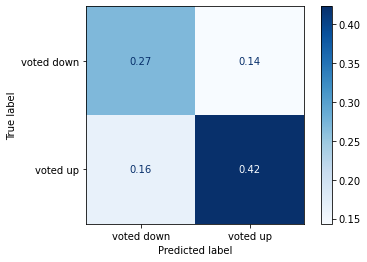

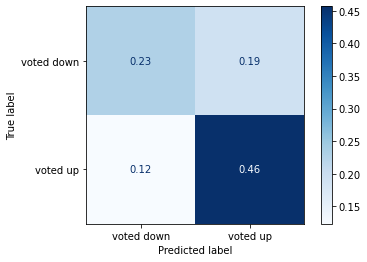

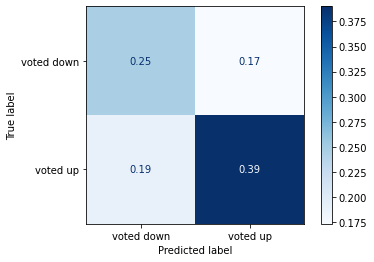

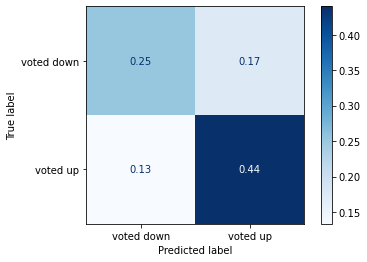

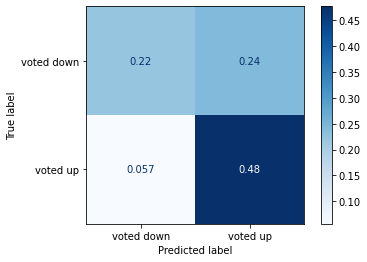

In [6]:
# SPLIT, TRAIN, PREDICT, GRAPH
total_score= 0
kfold= KFold(K_FOLDS, shuffle=True, random_state=1)
for train_index1, test_index1 in kfold.split(x):
    x_trains= []
    x_tests= []
    y_trains= []
    y_tests= []
    sub_x= []
    sub_y= []
    for index in test_index1:
        x_tests.append(x[index])
        y_tests.append(y[index])
    for index in train_index1:
        sub_x.append(x[index])
        sub_y.append(y[index])
    kfold= KFold(K_FOLDS - 1, shuffle=True, random_state=1)
    for train_index2, test_index2 in kfold.split(sub_x):
        x_train= []
        y_train= []
        for index in train_index2:
            x_train.append(sub_x[index])
            y_train.append(sub_y[index])
        x_trains+= x_train
        y_trains+= y_train
    clf= MLPClassifier(hidden_layer_sizes=(amount_features, int(amount_features/2), int(amount_features/4)), activation="relu", solver="adam", random_state=1).fit(x_trains, y_trains)
    y_preds= clf.predict(x_tests)
    total_score+= clf.score(x_tests, y_tests)
    try:
        #print("overall accuracy: ", clf.score(x_tests, y_tests))
        fig= plot_confusion_matrix(clf, x_tests, y_tests, display_labels=["voted down", "voted up"], cmap=plt.cm.Blues, normalize="all")
    except ValueError:
        pass
print(total_score / K_FOLDS)